# Classifying Essential Genes with Bitome

## Setup

### Import Required Packages

In [4]:
from pathlib import Path
import sys

from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from xgboost import XGBClassifier

BITOME_KB_PATH = Path('..', 'bitome-kb')
sys.path.append(BITOME_KB_PATH.absolute().as_posix())

from bitome.core import Bitome

### Define Global Variables

In [5]:
DATA_PATH = Path('..', 'data', 'classification')
LOCAL_CACHE_PATH = Path('..', 'local_cache')
FIG_PATH = Path('..', 'figures', 'figure_4')

### Load Pre-Prepared Bitome Knowledgebase

In [6]:
bitome = Bitome.init_from_file(Path(LOCAL_CACHE_PATH, 'bitome.pkl'))

## Essential Genes

### Prepare Feature Matrices

Similar to ALE SNPs above, we want to use the sum-across-features approach as well as the raw bitome matrix approach

In [15]:
# load the locus tags and SNP labels for training
ess_train_labels = pd.read_csv(Path(DATA_PATH, 'essential_train.csv'), index_col=0, squeeze=True)

y_ess = ess_train_labels.values

# extract the sub-matrix for each locus tag; ensure that they are all in the same "orientation";
# i.e. flip the reverse-strand matrices so that the translation start site is always on the "left"
ess_genes = []
ess_gene_sub_matrices = []
for locus_tag in ess_train_labels.index:
    
    # find the Gene object from the Bitome KB
    for g in bitome.genes:
        if g.locus_tag == locus_tag:
            gene = g
            ess_genes.append(gene)
            break
            
    # pull out the relevant portion of the matrix
    location = gene.location
    gene_range = location.start.position, location.end.position
    sub_matrix = bitome.extract(column_range=gene_range).tocsc()
    
    strand = location.strand
    if strand == -1:
        sub_matrix = sub_matrix[:, ::-1]
    
    ess_gene_sub_matrices.append(sub_matrix)

#### Summing Across Gene Positions

In [18]:
# now we can form the sum-across-the-positions version of the feature matrix
# should have dimensions n_genes, n_features
X_ess_sum = np.array([np.asarray(sub_mat.sum(axis=1)).flatten() for sub_mat in ess_gene_sub_matrices])
print(X_ess_sum.shape)

# also make sure to scale this summed matrix to ensure more equal feature importances
scaler = StandardScaler()
X_ess_sum = scaler.fit_transform(X_ess_sum)

(3349, 1634)


### Define Models to Try

In [19]:
models_to_try = {
    'LR': LogisticRegression(
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        random_state=42
    ),
    'SVM': LinearSVC(
        penalty='l1',
        class_weight='balanced',
        dual=False,
        random_state=42,
        verbose=1
    ),
    'RF': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        class_weight='balanced',
        random_state=42,
        verbose=1
    ),
    'NN': MLPClassifier(verbose=1),
    'XGBoost': XGBClassifier(verbose=1)
}

X_to_try = {
    'sum': X_ess_sum
}

### Model Selection

In [22]:
result_df = pd.DataFrame(
    columns=['model', 'x_matrix', 'train', 'test']
)

n_cv = 5

for model_name, model in models_to_try.items():
    print(f'{model_name}\n')

    for X_name, X in X_to_try.items():

        cv_result = cross_validate(
            model,
            X,
            y=y_ess,
            cv=n_cv,
            scoring='accuracy',
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )
        
        sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * n_cv,
                'x_matrix': [X_name] * n_cv,
                'train': cv_result['train_score'],
                'test': cv_result['test_score']
            }
        )

        result_df = result_df.append(sub_result_df)

LR



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   12.3s finished


SVM



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   19.6s finished


RF



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.9s finished


NN



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   18.8s finished


XGBoost



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   32.3s finished


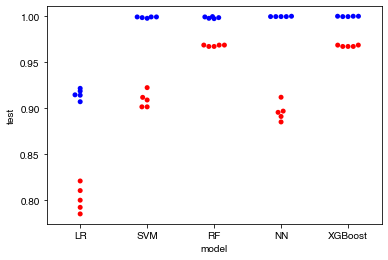

In [23]:
_, ax = plt.subplots()
sns.swarmplot(x='model', y='train', data=result_df, color='b', ax=ax)
sns.swarmplot(x='model', y='test', data=result_df, color='r', ax=ax)

### TF/Keras Neural Net Sandbox

Initial bias setting from: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [24]:
val_cutoff = int(X_ess_sum.shape[0]*0.8)

X = tf.convert_to_tensor(X_ess_sum[:val_cutoff, :])
y = tf.convert_to_tensor(y_ess[:val_cutoff].reshape((-1, 1)))
X_val = tf.convert_to_tensor(X_ess_sum[val_cutoff:, :])
y_val = tf.convert_to_tensor(y_ess[val_cutoff:].reshape((-1, 1)))

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=[0, 1],
    y=y_ess[:val_cutoff]
)
class_weight_dict = {k: v for k, v in zip([0, 1], class_weights)}

neg, pos = np.bincount(y_ess[:val_cutoff])
initial_bias = np.log([pos/neg])

In [25]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers_big', 1, 5)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), 100, 500, 10), activation='relu'))
    model.add(layers.Dropout(hp.Float('rate', 0, 1)))
    model.add(layers.Dense(units=hp.Int('units_small', 25, 200, 5), activation='relu'))
    model.add(layers.Dense(
        1,
        activation='sigmoid',
        bias_initializer=tf.keras.initializers.Constant(initial_bias)
    ))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [26]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=100,
    executions_per_trial=3,
    directory=LOCAL_CACHE_PATH,
    project_name='ess_wide'
)

In [27]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

tuner.search(
    X, y,
    epochs=50,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 1.00 - ETA: 0s - loss: 3.7375 - accuracy: 0.97 - ETA: 0s - loss: 2.7998 - accuracy: 0.68 - ETA: 0s - loss: 2.1821 - accuracy: 0.70 - ETA: 0s - loss: 1.9080 - accuracy: 0.69 - 0s 5ms/step - loss: 1.8096 - accuracy: 0.6585 - val_loss: 0.7755 - val_accuracy: 0.6881
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.0271 - accuracy: 0.87 - ETA: 0s - loss: 0.8078 - accuracy: 0.65 - ETA: 0s - loss: 0.8202

Epoch 19/50
84/84 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 1.00 - ETA: 0s - loss: 0.0782 - accuracy: 0.96 - ETA: 0s - loss: 0.1027 - accuracy: 0.96 - ETA: 0s - loss: 0.1068 - accuracy: 0.96 - 0s 2ms/step - loss: 0.1102 - accuracy: 0.9657 - val_loss: 0.3600 - val_accuracy: 0.9299
Epoch 20/50
84/84 [==============================] - ETA: 0s - loss: 0.1233 - accuracy: 0.96 - ETA: 0s - loss: 0.1495 - accuracy: 0.94 - ETA: 0s - loss: 0.1285 - accuracy: 0.95 - 0s 2ms/step - loss: 0.1808 - accuracy: 0.9537 - val_loss: 0.9010 - val_accuracy: 0.9015
Epoch 21/50
84/84 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.96 - ETA: 0s - loss: 1.6741 - accuracy: 0.87 - ETA: 0s - loss: 1.3382 - accuracy: 0.88 - ETA: 0s - loss: 1.4493 - accuracy: 0.90 - 0s 3ms/step - loss: 1.3706 - accuracy: 0.9007 - val_loss: 0.2284 - val_accuracy: 0.9642
Epoch 22/50
84/84 [==============================] - ETA: 0s - loss: 1.0885 - accuracy: 0.96 - ETA: 0s - loss: 0.88

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 4.1226 - accuracy: 0.90 - ETA: 0s - loss: 1.7792 - accuracy: 0.95 - ETA: 0s - loss: 1.5256 - accuracy: 0.95 - ETA: 0s - loss: 1.4071 - accuracy: 0.94 - ETA: 0s - loss: 1.2865 - accuracy: 0.91 - 0s 5ms/step - loss: 1.2152 - accuracy: 0.9015 - val_loss: 0.4215 - val_accuracy: 0.8343
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.5378 - accuracy: 0.84 - ETA: 0s - loss: 0.8915 - accuracy: 0.79 - ETA: 0s - loss: 0.7470

84/84 [==============================] - 0s 3ms/step - loss: 0.0610 - accuracy: 0.9798 - val_loss: 0.2070 - val_accuracy: 0.9448
Epoch 00011: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 7.9764 - accuracy: 0.84 - ETA: 0s - loss: 1.6208 - accuracy: 0.96 - ETA: 0s - loss: 1.7683 - accuracy: 0.96 - ETA: 0s - loss: 1.6120 - accuracy: 0.96 - ETA: 0s - loss: 1.4627 - accuracy: 0.96 - 0s 5ms/step - loss: 1.4588 - accuracy: 0.9645 - val_loss: 0.2081 - val_accuracy: 0.9657
E

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 4.4136 - accuracy: 0.87 - ETA: 0s - loss: 34.2742 - accuracy: 0.890 - ETA: 0s - loss: 56.3620 - accuracy: 0.884 - ETA: 0s - loss: 47.4089 - accuracy: 0.826 - ETA: 0s - loss: 55.0649 - accuracy: 0.711 - ETA: 0s - loss: 61.2666 - accuracy: 0.685 - ETA: 0s - loss: 55.2658 - accuracy: 0.667 - ETA: 0s - loss: 49.5326 - accuracy: 0.699 - 1s 7ms/step - loss: 47.6434 - accuracy: 0.7044 - val_loss: 2.6490 - val_accuracy: 0.9716
Epoch 2/50
84/84 

84/84 [==============================] - ETA: 0s - loss: 0.5002 - accuracy: 0.0000e+ - ETA: 0s - loss: 0.7082 - accuracy: 0.3638   - ETA: 0s - loss: 0.6974 - accuracy: 0.61 - ETA: 0s - loss: 0.6852 - accuracy: 0.71 - ETA: 0s - loss: 0.7726 - accuracy: 0.76 - ETA: 0s - loss: 0.7820 - accuracy: 0.62 - ETA: 0s - loss: 0.7661 - accuracy: 0.52 - ETA: 0s - loss: 0.7622 - accuracy: 0.52 - 0s 5ms/step - loss: 0.7622 - accuracy: 0.5211 - val_loss: 0.4618 - val_accuracy: 0.9522
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 1.1631 - accuracy: 0.90 - ETA: 0s - loss: 1.0133 - accuracy: 0.91 - ETA: 0s - loss: 0.9046 - accuracy: 0.78 - ETA: 0s - loss: 0.8522 - accuracy: 0.82 - ETA: 0s - loss: 0.8169 - accuracy: 0.85 - ETA: 0s - loss: 0.7897 - accuracy: 0.87 - ETA: 0s - loss: 0.7654 - accuracy: 0.89 - 0s 4ms/step - loss: 0.7786 - accuracy: 0.8936 - val_loss: 0.3579 - val_accuracy: 0.9642
Epoch 11/50
84/84 [==============================] - 0s 4ms/step - loss: 1.0633 - accuracy: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.96 - ETA: 0s - loss: 2.8454 - accuracy: 0.97 - ETA: 0s - loss: 2.2341 - accuracy: 0.97 - ETA: 0s - loss: 2.1097 - accuracy: 0.91 - ETA: 0s - loss: 1.7566 - accuracy: 0.85 - ETA: 0s - loss: 1.7244 - accuracy: 0.86 - ETA: 0s - loss: 1.7309 - accuracy: 0.80 - 1s 6ms/step - loss: 1.7309 - accuracy: 0.8037 - val_loss: 0.8991 - val_accuracy: 0.5418
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6200

Epoch 19/50
84/84 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.96 - ETA: 0s - loss: 0.0466 - accuracy: 0.98 - ETA: 0s - loss: 0.0628 - accuracy: 0.97 - ETA: 0s - loss: 0.0709 - accuracy: 0.97 - ETA: 0s - loss: 0.0901 - accuracy: 0.96 - ETA: 0s - loss: 0.0781 - accuracy: 0.96 - 0s 4ms/step - loss: 0.0860 - accuracy: 0.9694 - val_loss: 0.5221 - val_accuracy: 0.9104
Epoch 20/50
84/84 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.93 - ETA: 0s - loss: 1.1166 - accuracy: 0.93 - ETA: 0s - loss: 0.8479 - accuracy: 0.89 - ETA: 0s - loss: 0.6896 - accuracy: 0.89 - ETA: 0s - loss: 0.5600 - accuracy: 0.90 - ETA: 0s - loss: 0.4986 - accuracy: 0.91 - ETA: 0s - loss: 0.4367 - accuracy: 0.91 - 0s 4ms/step - loss: 0.4257 - accuracy: 0.9160 - val_loss: 0.4767 - val_accuracy: 0.8955
Epoch 21/50
84/84 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.90 - ETA: 0s - loss: 0.1422 - accuracy: 0.94 - ETA: 0s - loss: 0.1016 - accuracy: 

Epoch 00020: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.8641 - accuracy: 0.96 - ETA: 0s - loss: 3.3817 - accuracy: 0.96 - ETA: 0s - loss: 2.5896 - accuracy: 0.94 - ETA: 0s - loss: 2.0132 - accuracy: 0.87 - ETA: 0s - loss: 1.7438 - accuracy: 0.84 - ETA: 0s - loss: 1.6087 - accuracy: 0.82 - ETA: 0s - loss: 1.5242 - accuracy: 0.77 - 0s 6ms/step - loss: 1.5454 - accuracy: 0.7719 - val_loss: 0.3779 - val_accuracy: 0.8791
Epoch 2/50
84/84 [============================

Epoch 19/50
84/84 [==============================] - ETA: 0s - loss: 0.4784 - accuracy: 0.87 - ETA: 0s - loss: 0.2249 - accuracy: 0.93 - ETA: 0s - loss: 0.1967 - accuracy: 0.93 - ETA: 0s - loss: 0.1686 - accuracy: 0.93 - ETA: 0s - loss: 0.1649 - accuracy: 0.93 - ETA: 0s - loss: 0.1559 - accuracy: 0.94 - 0s 4ms/step - loss: 0.1517 - accuracy: 0.9451 - val_loss: 0.6506 - val_accuracy: 0.9284
Epoch 20/50
84/84 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 0.96 - ETA: 0s - loss: 0.0820 - accuracy: 0.96 - ETA: 0s - loss: 0.0733 - accuracy: 0.95 - ETA: 0s - loss: 0.0590 - accuracy: 0.96 - ETA: 0s - loss: 0.0702 - accuracy: 0.96 - ETA: 0s - loss: 0.0790 - accuracy: 0.96 - ETA: 0s - loss: 0.0885 - accuracy: 0.96 - 0s 4ms/step - loss: 0.0863 - accuracy: 0.9653 - val_loss: 1.0102 - val_accuracy: 0.9075
Epoch 21/50
84/84 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 1.00 - ETA: 0s - loss: 0.2708 - accuracy: 0.92 - ETA: 0s - loss: 0.3068 - accuracy: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 3.2255 - accuracy: 0.93 - ETA: 0s - loss: 1.5011 - accuracy: 0.87 - ETA: 0s - loss: 1.4089 - accuracy: 0.78 - ETA: 0s - loss: 1.1789 - accuracy: 0.72 - ETA: 0s - loss: 1.0709 - accuracy: 0.71 - ETA: 0s - loss: 1.0294 - accuracy: 0.70 - 0s 6ms/step - loss: 1.1089 - accuracy: 0.6980 - val_loss: 0.7440 - val_accuracy: 0.6030
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5348 - accuracy: 0.59 - ETA: 0s - loss: 0.5765

Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.1309 - accuracy: 0.96 - ETA: 0s - loss: 0.0819 - accuracy: 0.96 - ETA: 0s - loss: 0.0842 - accuracy: 0.96 - ETA: 0s - loss: 0.1147 - accuracy: 0.95 - ETA: 0s - loss: 0.1281 - accuracy: 0.94 - ETA: 0s - loss: 0.1312 - accuracy: 0.94 - 0s 4ms/step - loss: 0.1312 - accuracy: 0.9466 - val_loss: 0.4662 - val_accuracy: 0.8791
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.0321 - accuracy: 1.00 - ETA: 0s - loss: 0.2797 - accuracy: 0.94 - ETA: 0s - loss: 0.1717 - accuracy: 0.96 - ETA: 0s - loss: 0.1605 - accuracy: 0.95 - ETA: 0s - loss: 0.1620 - accuracy: 0.95 - ETA: 0s - loss: 0.1640 - accuracy: 0.95 - 0s 4ms/step - loss: 0.1683 - accuracy: 0.9459 - val_loss: 0.6552 - val_accuracy: 0.8448
Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 1.00 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 0s - loss: 0.1117 - accuracy: 0.96 - ETA: 0s - loss: 0.1071 - accuracy: 0

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 4.3291 - accuracy: 0.93 - ETA: 0s - loss: 21.2702 - accuracy: 0.906 - ETA: 0s - loss: 17.2737 - accuracy: 0.799 - ETA: 0s - loss: 11.6343 - accuracy: 0.835 - ETA: 0s - loss: 9.1748 - accuracy: 0.847 - ETA: 0s - loss: 7.6104 - accuracy: 0.82 - 0s 5ms/step - loss: 7.4043 - accuracy: 0.8261 - val_loss: 0.2328 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 2.4208 - accuracy: 0.81 - ETA: 0s - loss:

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 3.1860 - accuracy: 0.93 - ETA: 0s - loss: 1.5632 - accuracy: 0.96 - ETA: 0s - loss: 1.3216 - accuracy: 0.96 - ETA: 0s - loss: 1.1974 - accuracy: 0.94 - ETA: 0s - loss: 1.1969 - accuracy: 0.89 - 0s 5ms/step - loss: 1.1830 - accuracy: 0.8865 - val_loss: 0.7872 - val_accuracy: 0.6507
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7653 - accuracy: 0.62 - ETA: 0s - loss: 1.0482 - accuracy: 0.62 - ETA: 0s - loss: 0.8513

84/84 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.93 - ETA: 0s - loss: 0.1263 - accuracy: 0.96 - ETA: 0s - loss: 0.1096 - accuracy: 0.96 - ETA: 0s - loss: 0.1031 - accuracy: 0.96 - 0s 3ms/step - loss: 0.0984 - accuracy: 0.9608 - val_loss: 0.1942 - val_accuracy: 0.9522
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.1428 - accuracy: 0.93 - ETA: 0s - loss: 0.0620 - accuracy: 0.97 - ETA: 0s - loss: 0.0573 - accuracy: 0.97 - ETA: 0s - loss: 0.0712 - accuracy: 0.97 - 0s 3ms/step - loss: 0.0658 - accuracy: 0.9716 - val_loss: 0.2448 - val_accuracy: 0.9328
Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 1.00 - ETA: 0s - loss: 0.1113 - accuracy: 0.97 - ETA: 0s - loss: 0.1238 - accuracy: 0.94 - ETA: 0s - loss: 0.0984 - accuracy: 0.95 - 0s 3ms/step - loss: 0.0886 - accuracy: 0.9649 - val_loss: 0.2532 - val_accuracy: 0.9373
Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 0.0214 - accurac

Epoch 25/50
84/84 [==============================] - ETA: 0s - loss: 3.5971e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0015 - accuracy: 1.0000   - ETA: 0s - loss: 0.0026 - accuracy: 0.99 - ETA: 0s - loss: 0.0024 - accuracy: 0.99 - 0s 3ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.3073 - val_accuracy: 0.9612
Epoch 26/50
84/84 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 1.00 - ETA: 0s - loss: 0.0029 - accuracy: 1.00 - ETA: 0s - loss: 0.0028 - accuracy: 1.00 - ETA: 0s - loss: 0.0027 - accuracy: 0.99 - 0s 3ms/step - loss: 0.0027 - accuracy: 0.9996 - val_loss: 0.3165 - val_accuracy: 0.9612
Epoch 27/50
84/84 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.00 - ETA: 0s - loss: 0.0026 - accuracy: 0.99 - ETA: 0s - loss: 0.0021 - accuracy: 0.99 - ETA: 0s - loss: 0.0027 - accuracy: 0.99 - 0s 3ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.3214 - val_accuracy: 0.9627
Epoch 28/50
84/84 [==============================] - 0s 3ms/step 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.7319 - accuracy: 0.96 - ETA: 0s - loss: 1.8940 - accuracy: 0.97 - ETA: 0s - loss: 1.3712 - accuracy: 0.74 - ETA: 0s - loss: 1.2179 - accuracy: 0.74 - ETA: 0s - loss: 1.0927 - accuracy: 0.74 - ETA: 0s - loss: 1.0263 - accuracy: 0.71 - ETA: 0s - loss: 1.0020 - accuracy: 0.68 - 1s 6ms/step - loss: 0.9785 - accuracy: 0.6850 - val_loss: 0.3069 - val_accuracy: 0.9388
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7418

84/84 [==============================] - ETA: 0s - loss: 0.0804 - accuracy: 0.93 - ETA: 0s - loss: 0.0381 - accuracy: 0.97 - ETA: 0s - loss: 0.0626 - accuracy: 0.96 - ETA: 0s - loss: 0.0533 - accuracy: 0.97 - ETA: 0s - loss: 0.0528 - accuracy: 0.97 - ETA: 0s - loss: 0.0490 - accuracy: 0.97 - 0s 4ms/step - loss: 0.0486 - accuracy: 0.9757 - val_loss: 1.9185 - val_accuracy: 0.9284
Epoch 26/50
84/84 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 1.00 - ETA: 0s - loss: 0.4760 - accuracy: 0.98 - ETA: 0s - loss: 0.5482 - accuracy: 0.91 - ETA: 0s - loss: 0.5981 - accuracy: 0.89 - ETA: 0s - loss: 0.5441 - accuracy: 0.89 - ETA: 0s - loss: 0.5044 - accuracy: 0.88 - ETA: 0s - loss: 0.4547 - accuracy: 0.89 - 0s 4ms/step - loss: 0.4454 - accuracy: 0.8962 - val_loss: 0.6321 - val_accuracy: 0.8388
Epoch 27/50
84/84 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.84 - ETA: 0s - loss: 0.3256 - accuracy: 0.89 - ETA: 0s - loss: 0.2796 - accuracy: 0.87 - ETA: 

84/84 [==============================] - ETA: 0s - loss: 3.2945e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0941 - accuracy: 0.9531   - ETA: 0s - loss: 0.0906 - accuracy: 0.95 - ETA: 0s - loss: 0.0855 - accuracy: 0.97 - ETA: 0s - loss: 0.0724 - accuracy: 0.97 - ETA: 0s - loss: 0.0713 - accuracy: 0.97 - ETA: 0s - loss: 0.0683 - accuracy: 0.97 - 0s 4ms/step - loss: 0.0691 - accuracy: 0.9776 - val_loss: 8.3478 - val_accuracy: 0.9119
Epoch 29/50
84/84 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 1.00 - ETA: 0s - loss: 0.0236 - accuracy: 0.98 - ETA: 0s - loss: 0.0276 - accuracy: 0.98 - ETA: 0s - loss: 0.0246 - accuracy: 0.98 - ETA: 0s - loss: 0.0308 - accuracy: 0.98 - ETA: 0s - loss: 0.0270 - accuracy: 0.98 - ETA: 0s - loss: 0.0548 - accuracy: 0.98 - ETA: 0s - loss: 0.0502 - accuracy: 0.99 - 0s 5ms/step - loss: 0.0497 - accuracy: 0.9895 - val_loss: 7.8415 - val_accuracy: 0.9134
Epoch 30/50
84/84 [==============================] - 0s 5ms/step - loss: 0.0205 - accuracy: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.1639 - accuracy: 0.93 - ETA: 0s - loss: 21.4525 - accuracy: 0.855 - ETA: 0s - loss: 14.7652 - accuracy: 0.895 - ETA: 0s - loss: 12.1877 - accuracy: 0.918 - ETA: 0s - loss: 10.1416 - accuracy: 0.929 - ETA: 0s - loss: 8.6213 - accuracy: 0.937 - ETA: 0s - loss: 7.5422 - accuracy: 0.94 - 1s 6ms/step - loss: 6.9687 - accuracy: 0.9451 - val_loss: 0.1547 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - los

Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.9824 - accuracy: 0.62 - ETA: 0s - loss: 0.7373 - accuracy: 0.61 - ETA: 0s - loss: 0.7963 - accuracy: 0.61 - ETA: 0s - loss: 0.8710 - accuracy: 0.61 - ETA: 0s - loss: 0.8141 - accuracy: 0.59 - ETA: 0s - loss: 0.8389 - accuracy: 0.60 - ETA: 0s - loss: 0.8132 - accuracy: 0.60 - 0s 4ms/step - loss: 0.8132 - accuracy: 0.6025 - val_loss: 0.2671 - val_accuracy: 0.9716
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.8842 - accuracy: 0.53 - ETA: 0s - loss: 0.6717 - accuracy: 0.60 - ETA: 0s - loss: 0.6359 - accuracy: 0.65 - ETA: 0s - loss: 0.7097 - accuracy: 0.67 - ETA: 0s - loss: 0.7022 - accuracy: 0.69 - ETA: 0s - loss: 0.7479 - accuracy: 0.69 - 0s 4ms/step - loss: 0.7551 - accuracy: 0.6887 - val_loss: 0.2856 - val_accuracy: 0.9716
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 1.2659 - accuracy: 0.59 - ETA: 0s - loss: 0.7608 - accuracy: 0.64 - ETA: 0s - loss: 0.6846 - accuracy: 0.6

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.6884 - accuracy: 0.84 - ETA: 0s - loss: 3.9256 - accuracy: 0.83 - ETA: 0s - loss: 3.1098 - accuracy: 0.84 - ETA: 0s - loss: 3.4948 - accuracy: 0.84 - ETA: 0s - loss: 3.5941 - accuracy: 0.84 - ETA: 0s - loss: 3.9616 - accuracy: 0.84 - 1s 6ms/step - loss: 3.7653 - accuracy: 0.8492 - val_loss: 0.1451 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.2455 - accuracy: 0.90 - ETA: 0s - loss: 2.9495

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 1.00 - ETA: 0s - loss: 4.9380 - accuracy: 0.83 - ETA: 0s - loss: 3.3668 - accuracy: 0.83 - ETA: 0s - loss: 2.5958 - accuracy: 0.79 - 0s 4ms/step - loss: 2.4578 - accuracy: 0.7764 - val_loss: 0.1787 - val_accuracy: 0.9657
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.96 - ETA: 0s - loss: 0.9843 - accuracy: 0.78 - ETA: 0s - loss: 0.9489 - accuracy: 0.80 - ETA: 0s - loss: 0.8174

Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.7365 - accuracy: 0.93 - ETA: 0s - loss: 1.0627 - accuracy: 0.85 - ETA: 0s - loss: 1.0202 - accuracy: 0.88 - ETA: 0s - loss: 1.3883 - accuracy: 0.90 - 0s 2ms/step - loss: 1.3883 - accuracy: 0.9033 - val_loss: 0.9793 - val_accuracy: 0.9657
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 2.7753 - accuracy: 0.87 - ETA: 0s - loss: 0.9856 - accuracy: 0.91 - ETA: 0s - loss: 1.0830 - accuracy: 0.91 - 0s 2ms/step - loss: 1.0355 - accuracy: 0.9119 - val_loss: 0.4280 - val_accuracy: 0.8821
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.2207 - accuracy: 0.87 - ETA: 0s - loss: 1.2281 - accuracy: 0.91 - ETA: 0s - loss: 1.0567 - accuracy: 0.94 - ETA: 0s - loss: 0.9394 - accuracy: 0.94 - 0s 2ms/step - loss: 0.9508 - accuracy: 0.9496 - val_loss: 0.4054 - val_accuracy: 0.9716
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.1988 - accuracy: 1.00 - ETA: 0s - loss: 0.8523 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.7740 - accuracy: 0.96 - ETA: 0s - loss: 1.5245 - accuracy: 0.97 - ETA: 0s - loss: 1.5577 - accuracy: 0.96 - 0s 3ms/step - loss: 1.4477 - accuracy: 0.9578 - val_loss: 0.2689 - val_accuracy: 0.9403
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.0303 - accuracy: 0.90 - ETA: 0s - loss: 0.8233 - accuracy: 0.89 - ETA: 0s - loss: 0.7053 - accuracy: 0.84 - 0s 2ms/step - loss: 0.7034 - accuracy: 0.8369 - val_loss: 0.4633

84/84 [==============================] - ETA: 0s - loss: 1.6873 - accuracy: 0.96 - ETA: 0s - loss: 1.5664 - accuracy: 0.95 - ETA: 0s - loss: 1.2513 - accuracy: 0.94 - 0s 3ms/step - loss: 1.2351 - accuracy: 0.9373 - val_loss: 0.3643 - val_accuracy: 0.8836
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.1557 - accuracy: 0.90 - ETA: 0s - loss: 0.7512 - accuracy: 0.84 - ETA: 0s - loss: 0.6841 - accuracy: 0.81 - 0s 2ms/step - loss: 0.6668 - accuracy: 0.8085 - val_loss: 0.5101 - val_accuracy: 0.8015
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.5213 - accuracy: 0.78 - ETA: 0s - loss: 0.5256 - accuracy: 0.80 - ETA: 0s - loss: 0.4957 - accuracy: 0.81 - 0s 2ms/step - loss: 0.4944 - accuracy: 0.8238 - val_loss: 0.4620 - val_accuracy: 0.8164
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.4911 - accuracy: 0.84 - ETA: 0s - loss: 0.3831 - accuracy: 0.84 - ETA: 0s - loss: 0.3828 - accuracy: 0.86 - 0s 2ms/step - loss: 0.4021 - accura

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 5.3143 - accuracy: 0.90 - ETA: 0s - loss: 2.9661 - accuracy: 0.86 - ETA: 0s - loss: 4.0422 - accuracy: 0.86 - ETA: 0s - loss: 4.0074 - accuracy: 0.86 - ETA: 0s - loss: 3.6386 - accuracy: 0.87 - 0s 5ms/step - loss: 3.7125 - accuracy: 0.8735 - val_loss: 0.1472 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4099 - accuracy: 0.90 - ETA: 0s - loss: 3.7056 - accuracy: 0.89 - ETA: 0s - loss: 2.6452

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 6.1804 - accuracy: 0.87 - ETA: 0s - loss: 1.4911 - accuracy: 0.78 - ETA: 0s - loss: 1.1358 - accuracy: 0.73 - ETA: 0s - loss: 1.1048 - accuracy: 0.68 - ETA: 0s - loss: 1.0865 - accuracy: 0.69 - ETA: 0s - loss: 1.0292 - accuracy: 0.68 - ETA: 0s - loss: 0.9645 - accuracy: 0.70 - 1s 7ms/step - loss: 0.9555 - accuracy: 0.7107 - val_loss: 0.7468 - val_accuracy: 0.6328
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.3980

84/84 [==============================] - ETA: 0s - loss: 0.3269 - accuracy: 0.96 - ETA: 0s - loss: 0.4740 - accuracy: 0.92 - ETA: 0s - loss: 0.5429 - accuracy: 0.87 - ETA: 0s - loss: 0.5086 - accuracy: 0.87 - ETA: 0s - loss: 0.5022 - accuracy: 0.86 - ETA: 0s - loss: 0.4652 - accuracy: 0.86 - ETA: 0s - loss: 0.4474 - accuracy: 0.87 - ETA: 0s - loss: 0.4361 - accuracy: 0.86 - 0s 5ms/step - loss: 0.4157 - accuracy: 0.8686 - val_loss: 3.4497 - val_accuracy: 0.9403
Epoch 21/50
84/84 [==============================] - ETA: 0s - loss: 0.1402 - accuracy: 0.96 - ETA: 0s - loss: 0.4235 - accuracy: 0.91 - ETA: 0s - loss: 0.3928 - accuracy: 0.85 - ETA: 0s - loss: 0.3510 - accuracy: 0.87 - ETA: 0s - loss: 0.3178 - accuracy: 0.88 - ETA: 0s - loss: 0.2895 - accuracy: 0.89 - ETA: 0s - loss: 0.2671 - accuracy: 0.89 - ETA: 0s - loss: 0.2506 - accuracy: 0.90 - 0s 5ms/step - loss: 0.2505 - accuracy: 0.9052 - val_loss: 5.1255 - val_accuracy: 0.9149
Epoch 22/50
84/84 [==============================] - ETA: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 3.0474 - accuracy: 0.93 - ETA: 0s - loss: 6.2734 - accuracy: 0.69 - ETA: 0s - loss: 4.0886 - accuracy: 0.74 - ETA: 0s - loss: 3.2047 - accuracy: 0.82 - 0s 4ms/step - loss: 3.1391 - accuracy: 0.8253 - val_loss: 0.1876 - val_accuracy: 0.9642
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.9513 - accuracy: 0.90 - ETA: 0s - loss: 1.2165 - accuracy: 0.72 - ETA: 0s - loss: 1.0315 - accuracy: 0.78 - ETA: 0s - loss: 1.0155

84/84 [==============================] - ETA: 0s - loss: 2.0737 - accuracy: 0.93 - ETA: 0s - loss: 10.3801 - accuracy: 0.628 - ETA: 0s - loss: 5.3173 - accuracy: 0.694 - ETA: 0s - loss: 3.7669 - accuracy: 0.68 - 0s 3ms/step - loss: 3.5862 - accuracy: 0.6797 - val_loss: 0.4038 - val_accuracy: 0.8493
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.6272 - accuracy: 0.71 - ETA: 0s - loss: 0.7589 - accuracy: 0.69 - ETA: 0s - loss: 0.8064 - accuracy: 0.74 - ETA: 0s - loss: 0.7616 - accuracy: 0.76 - 0s 2ms/step - loss: 0.7592 - accuracy: 0.7723 - val_loss: 0.3997 - val_accuracy: 0.8552
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.9584 - accuracy: 0.93 - ETA: 0s - loss: 0.4114 - accuracy: 0.82 - ETA: 0s - loss: 0.4120 - accuracy: 0.82 - ETA: 0s - loss: 0.5253 - accuracy: 0.82 - 0s 2ms/step - loss: 0.5253 - accuracy: 0.8294 - val_loss: 1.5988 - val_accuracy: 0.6164
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.6858 - accurac

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.1199 - accuracy: 0.96 - ETA: 0s - loss: 48.8544 - accuracy: 0.953 - ETA: 0s - loss: 54.0902 - accuracy: 0.884 - ETA: 0s - loss: 40.1926 - accuracy: 0.801 - 0s 4ms/step - loss: 37.3842 - accuracy: 0.7999 - val_loss: 0.7171 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 2.1281 - accuracy: 0.87 - ETA: 0s - loss: 6.7329 - accuracy: 0.72 - ETA: 0s - loss: 5.0326 - accuracy: 0.77 - ETA: 0s - loss:

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.96 - ETA: 0s - loss: 20.1361 - accuracy: 0.962 - ETA: 0s - loss: 18.6061 - accuracy: 0.863 - ETA: 0s - loss: 27.4819 - accuracy: 0.837 - ETA: 0s - loss: 23.2339 - accuracy: 0.795 - ETA: 0s - loss: 19.9248 - accuracy: 0.773 - 0s 5ms/step - loss: 21.8905 - accuracy: 0.7738 - val_loss: 1.0708 - val_accuracy: 0.6955
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.1475 - accuracy: 0.68 - ETA: 0s - l

Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 2.2390 - accuracy: 0.75 - ETA: 0s - loss: 1.8344 - accuracy: 0.84 - ETA: 0s - loss: 1.3366 - accuracy: 0.89 - ETA: 0s - loss: 1.3058 - accuracy: 0.88 - ETA: 0s - loss: 1.4024 - accuracy: 0.88 - ETA: 0s - loss: 1.4163 - accuracy: 0.88 - 0s 4ms/step - loss: 1.4056 - accuracy: 0.8806 - val_loss: 0.1842 - val_accuracy: 0.9716
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 1.0205 - accuracy: 0.84 - ETA: 0s - loss: 0.9574 - accuracy: 0.88 - ETA: 0s - loss: 1.0238 - accuracy: 0.89 - ETA: 0s - loss: 1.1420 - accuracy: 0.89 - ETA: 0s - loss: 1.0733 - accuracy: 0.89 - 0s 3ms/step - loss: 1.0813 - accuracy: 0.9015 - val_loss: 0.2369 - val_accuracy: 0.9716
Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 0.9293 - accuracy: 0.96 - ETA: 0s - loss: 0.9904 - accuracy: 0.92 - ETA: 0s - loss: 0.8298 - accuracy: 0.93 - ETA: 0s - loss: 0.9185 - accuracy: 0.93 - ETA: 0s - loss: 1.0986 - accuracy: 0.9

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 1.00 - ETA: 0s - loss: 1.6691 - accuracy: 0.97 - ETA: 0s - loss: 1.4732 - accuracy: 0.77 - ETA: 0s - loss: 1.2467 - accuracy: 0.72 - ETA: 0s - loss: 1.0853 - accuracy: 0.72 - 0s 5ms/step - loss: 1.0634 - accuracy: 0.7197 - val_loss: 0.8030 - val_accuracy: 0.5851
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.9402 - accuracy: 0.56 - ETA: 0s - loss: 0.7826 - accuracy: 0.66 - ETA: 0s - loss: 0.6748

84/84 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.37 - ETA: 0s - loss: 0.5947 - accuracy: 0.70 - ETA: 0s - loss: 0.5094 - accuracy: 0.75 - ETA: 0s - loss: 0.4581 - accuracy: 0.79 - ETA: 0s - loss: 0.5295 - accuracy: 0.77 - 0s 3ms/step - loss: 0.5303 - accuracy: 0.7839 - val_loss: 0.5002 - val_accuracy: 0.8209
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.87 - ETA: 0s - loss: 0.2662 - accuracy: 0.91 - ETA: 0s - loss: 0.3026 - accuracy: 0.88 - ETA: 0s - loss: 0.2901 - accuracy: 0.87 - 0s 3ms/step - loss: 0.2887 - accuracy: 0.8862 - val_loss: 0.4618 - val_accuracy: 0.8164
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.87 - ETA: 0s - loss: 0.2317 - accuracy: 0.88 - ETA: 0s - loss: 0.1969 - accuracy: 0.91 - ETA: 0s - loss: 0.2364 - accuracy: 0.90 - ETA: 0s - loss: 0.2477 - accuracy: 0.90 - 0s 3ms/step - loss: 0.2479 - accuracy: 0.9029 - val_loss: 0.7208 - val_accuracy: 0.7463
Epo

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 3.5449 - accuracy: 0.93 - ETA: 0s - loss: 2.0200 - accuracy: 0.95 - ETA: 0s - loss: 1.8742 - accuracy: 0.95 - ETA: 0s - loss: 1.7682 - accuracy: 0.95 - 0s 4ms/step - loss: 1.5157 - accuracy: 0.9518 - val_loss: 0.1438 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 1.00 - ETA: 0s - loss: 1.3679 - accuracy: 0.92 - ETA: 0s - loss: 1.2364 - accuracy: 0.90 - ETA: 0s - loss: 1.0871

84/84 [==============================] - ETA: 0s - loss: 5.0121 - accuracy: 0.90 - ETA: 0s - loss: 1.3774 - accuracy: 0.96 - ETA: 0s - loss: 1.5085 - accuracy: 0.96 - 0s 3ms/step - loss: 1.7256 - accuracy: 0.9578 - val_loss: 0.1463 - val_accuracy: 0.9687
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.93 - ETA: 0s - loss: 1.1853 - accuracy: 0.93 - ETA: 0s - loss: 1.0994 - accuracy: 0.92 - 0s 2ms/step - loss: 1.2209 - accuracy: 0.9115 - val_loss: 0.2973 - val_accuracy: 0.9239
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 1.5236 - accuracy: 0.84 - ETA: 0s - loss: 0.9386 - accuracy: 0.85 - ETA: 0s - loss: 0.9289 - accuracy: 0.85 - ETA: 0s - loss: 0.9141 - accuracy: 0.82 - ETA: 0s - loss: 0.8741 - accuracy: 0.82 - 0s 3ms/step - loss: 0.8794 - accuracy: 0.8205 - val_loss: 0.4454 - val_accuracy: 0.8373
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.6391 - accuracy: 0.78 - ETA: 0s - loss: 0.8031 - accuracy: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 1.00 - ETA: 0s - loss: 13.5255 - accuracy: 0.953 - ETA: 0s - loss: 7.6950 - accuracy: 0.919 - ETA: 0s - loss: 6.3049 - accuracy: 0.91 - ETA: 0s - loss: 5.1268 - accuracy: 0.90 - ETA: 0s - loss: 4.7157 - accuracy: 0.88 - ETA: 0s - loss: 4.2185 - accuracy: 0.86 - ETA: 0s - loss: 3.8453 - accuracy: 0.84 - 1s 7ms/step - loss: 3.7769 - accuracy: 0.8458 - val_loss: 0.3442 - val_accuracy: 0.8985
Epoch 2/50
84/84 [===========

84/84 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.96 - ETA: 0s - loss: 1.1253 - accuracy: 0.84 - ETA: 0s - loss: 1.3238 - accuracy: 0.87 - ETA: 0s - loss: 1.3141 - accuracy: 0.85 - ETA: 0s - loss: 1.2825 - accuracy: 0.85 - ETA: 0s - loss: 1.2522 - accuracy: 0.85 - ETA: 0s - loss: 1.2021 - accuracy: 0.85 - 0s 5ms/step - loss: 1.1981 - accuracy: 0.8559 - val_loss: 0.2409 - val_accuracy: 0.9701
Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 0.9737 - accuracy: 0.87 - ETA: 0s - loss: 0.6593 - accuracy: 0.78 - ETA: 0s - loss: 1.0712 - accuracy: 0.72 - ETA: 0s - loss: 1.0560 - accuracy: 0.75 - ETA: 0s - loss: 1.0469 - accuracy: 0.78 - ETA: 0s - loss: 1.0160 - accuracy: 0.79 - ETA: 0s - loss: 1.0060 - accuracy: 0.80 - 0s 5ms/step - loss: 0.9643 - accuracy: 0.8216 - val_loss: 0.2395 - val_accuracy: 0.9716
Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 1.7926 - accuracy: 0.87 - ETA: 0s - loss: 0.9741 - accuracy: 0.88 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.6950 - accuracy: 0.93 - ETA: 0s - loss: 4.9402 - accuracy: 0.96 - ETA: 0s - loss: 6.0188 - accuracy: 0.96 - ETA: 0s - loss: 7.3094 - accuracy: 0.96 - ETA: 0s - loss: 7.7501 - accuracy: 0.95 - ETA: 0s - loss: 7.3322 - accuracy: 0.94 - ETA: 0s - loss: 7.2708 - accuracy: 0.94 - 1s 6ms/step - loss: 7.1675 - accuracy: 0.9369 - val_loss: 0.7835 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.2092

84/84 [==============================] - 0s 5ms/step - loss: 0.9813 - accuracy: 0.7548 - val_loss: 0.1665 - val_accuracy: 0.9716
Epoch 00011: early stopping


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 3.8596 - accuracy: 0.84 - ETA: 0s - loss: 8.0239 - accuracy: 0.86 - ETA: 0s - loss: 5.7005 - accuracy: 0.71 - 0s 3ms/step - loss: 5.0396 - accuracy: 0.6700 - val_loss: 0.2066 - val_accuracy: 0.9522
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.0875 - accuracy: 0.53 - ETA: 0s - loss: 1.1895 - accuracy: 0.77 - ETA: 0s - loss: 1.1790 - accuracy: 0.73 - 0s 2ms/step - loss: 1.2389 - accuracy: 0.7283 - val_loss: 0.2161

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.9121 - accuracy: 0.96 - ETA: 0s - loss: 2.1689 - accuracy: 0.89 - ETA: 0s - loss: 1.5659 - accuracy: 0.81 - ETA: 0s - loss: 1.3676 - accuracy: 0.74 - ETA: 0s - loss: 1.3675 - accuracy: 0.74 - ETA: 0s - loss: 1.2833 - accuracy: 0.70 - ETA: 0s - loss: 1.1840 - accuracy: 0.70 - 1s 6ms/step - loss: 1.1581 - accuracy: 0.7085 - val_loss: 0.4813 - val_accuracy: 0.8149
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.2385

84/84 [==============================] - ETA: 0s - loss: 0.1934 - accuracy: 0.81 - ETA: 0s - loss: 0.3839 - accuracy: 0.82 - ETA: 0s - loss: 0.3179 - accuracy: 0.86 - ETA: 0s - loss: 0.3841 - accuracy: 0.85 - ETA: 0s - loss: 0.3598 - accuracy: 0.86 - ETA: 0s - loss: 0.3338 - accuracy: 0.87 - 0s 4ms/step - loss: 0.4007 - accuracy: 0.8694 - val_loss: 0.8072 - val_accuracy: 0.7164
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.4080 - accuracy: 0.81 - ETA: 0s - loss: 0.3994 - accuracy: 0.84 - ETA: 0s - loss: 0.3259 - accuracy: 0.87 - ETA: 0s - loss: 0.2762 - accuracy: 0.89 - ETA: 0s - loss: 0.2609 - accuracy: 0.89 - ETA: 0s - loss: 0.2873 - accuracy: 0.88 - 0s 4ms/step - loss: 0.2915 - accuracy: 0.8764 - val_loss: 0.4758 - val_accuracy: 0.8149
Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 0.2041 - accuracy: 0.84 - ETA: 0s - loss: 0.1190 - accuracy: 0.94 - ETA: 0s - loss: 0.1672 - accuracy: 0.95 - ETA: 0s - loss: 0.1891 - accuracy: 0.92 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 3.2305 - accuracy: 0.93 - ETA: 0s - loss: 2.1554 - accuracy: 0.96 - ETA: 0s - loss: 2.3280 - accuracy: 0.95 - ETA: 0s - loss: 1.9527 - accuracy: 0.96 - ETA: 0s - loss: 1.8580 - accuracy: 0.96 - ETA: 0s - loss: 1.7308 - accuracy: 0.96 - ETA: 0s - loss: 1.7602 - accuracy: 0.96 - ETA: 0s - loss: 1.7191 - accuracy: 0.96 - 1s 7ms/step - loss: 1.6353 - accuracy: 0.9619 - val_loss: 0.1449 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============

84/84 [==============================] - ETA: 0s - loss: 0.1818 - accuracy: 0.84 - ETA: 0s - loss: 0.3242 - accuracy: 0.88 - ETA: 0s - loss: 0.2761 - accuracy: 0.89 - ETA: 0s - loss: 0.2762 - accuracy: 0.90 - ETA: 0s - loss: 0.3203 - accuracy: 0.89 - ETA: 0s - loss: 0.3109 - accuracy: 0.89 - ETA: 0s - loss: 0.3151 - accuracy: 0.89 - ETA: 0s - loss: 0.3036 - accuracy: 0.88 - 0s 5ms/step - loss: 0.2995 - accuracy: 0.8899 - val_loss: 0.2033 - val_accuracy: 0.9388
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.1735 - accuracy: 0.81 - ETA: 0s - loss: 0.1271 - accuracy: 0.93 - ETA: 0s - loss: 0.2278 - accuracy: 0.94 - ETA: 0s - loss: 0.2816 - accuracy: 0.93 - ETA: 0s - loss: 0.2639 - accuracy: 0.92 - ETA: 0s - loss: 0.2843 - accuracy: 0.91 - ETA: 0s - loss: 0.2850 - accuracy: 0.91 - 0s 4ms/step - loss: 0.2842 - accuracy: 0.9141 - val_loss: 0.2292 - val_accuracy: 0.9254
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.93 - ETA: 0

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 1.00 - ETA: 0s - loss: 2.8846 - accuracy: 0.97 - ETA: 0s - loss: 2.7187 - accuracy: 0.96 - ETA: 0s - loss: 2.5426 - accuracy: 0.96 - ETA: 0s - loss: 2.3988 - accuracy: 0.96 - 1s 6ms/step - loss: 2.3114 - accuracy: 0.9672 - val_loss: 0.1399 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.5169 - accuracy: 0.96 - ETA: 0s - loss: 1.4757 - accuracy: 0.97 - ETA: 0s - loss: 1.6261

84/84 [==============================] - ETA: 0s - loss: 0.9950 - accuracy: 0.96 - ETA: 0s - loss: 3.8523 - accuracy: 0.94 - ETA: 0s - loss: 3.0160 - accuracy: 0.95 - ETA: 0s - loss: 2.4678 - accuracy: 0.95 - ETA: 0s - loss: 2.2527 - accuracy: 0.93 - 0s 5ms/step - loss: 2.0866 - accuracy: 0.9317 - val_loss: 0.1475 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.8246 - accuracy: 0.90 - ETA: 0s - loss: 1.8143 - accuracy: 0.90 - ETA: 0s - loss: 1.3953 - accuracy: 0.92 - ETA: 0s - loss: 1.4497 - accuracy: 0.91 - ETA: 0s - loss: 1.3709 - accuracy: 0.88 - 0s 3ms/step - loss: 1.3014 - accuracy: 0.8768 - val_loss: 0.1512 - val_accuracy: 0.9716
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 2.0184 - accuracy: 0.78 - ETA: 0s - loss: 1.0753 - accuracy: 0.79 - ETA: 0s - loss: 0.9905 - accuracy: 0.79 - ETA: 0s - loss: 0.9276 - accuracy: 0.80 - ETA: 0s - loss: 0.9647 - accuracy: 0.78 - 0s 3ms/step - loss: 0.9856 - accuracy: 0.7981 - v

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.1196 - accuracy: 0.84 - ETA: 0s - loss: 1.5952 - accuracy: 0.80 - ETA: 0s - loss: 1.7269 - accuracy: 0.81 - ETA: 0s - loss: 1.6245 - accuracy: 0.81 - ETA: 0s - loss: 1.6116 - accuracy: 0.82 - 0s 5ms/step - loss: 1.5230 - accuracy: 0.8238 - val_loss: 0.1291 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.87 - ETA: 0s - loss: 1.2449 - accuracy: 0.88 - ETA: 0s - loss: 1.4474

Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 1.4721 - accuracy: 0.93 - ETA: 0s - loss: 1.6641 - accuracy: 0.91 - ETA: 0s - loss: 1.8497 - accuracy: 0.91 - ETA: 0s - loss: 1.8392 - accuracy: 0.91 - ETA: 0s - loss: 1.7123 - accuracy: 0.91 - 0s 3ms/step - loss: 1.7136 - accuracy: 0.9149 - val_loss: 0.1528 - val_accuracy: 0.9731
Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 0.5156 - accuracy: 0.90 - ETA: 0s - loss: 1.9515 - accuracy: 0.88 - ETA: 0s - loss: 1.6575 - accuracy: 0.89 - ETA: 0s - loss: 1.6129 - accuracy: 0.89 - ETA: 0s - loss: 1.5575 - accuracy: 0.89 - 0s 3ms/step - loss: 1.5623 - accuracy: 0.8925 - val_loss: 0.1587 - val_accuracy: 0.9731
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.0628 - accuracy: 0.93 - ETA: 0s - loss: 1.7246 - accuracy: 0.89 - ETA: 0s - loss: 1.4465 - accuracy: 0.89 - ETA: 0s - loss: 1.7723 - accuracy: 0.87 - ETA: 0s - loss: 1.6505 - accuracy: 0.88 - 0s 3ms/step - loss: 1.5466 - accura

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.7519 - accuracy: 0.96 - ETA: 0s - loss: 22.8970 - accuracy: 0.960 - ETA: 0s - loss: 13.5065 - accuracy: 0.881 - ETA: 0s - loss: 10.0684 - accuracy: 0.875 - ETA: 0s - loss: 7.9815 - accuracy: 0.896 - ETA: 0s - loss: 6.7887 - accuracy: 0.90 - ETA: 0s - loss: 5.8398 - accuracy: 0.90 - ETA: 0s - loss: 5.1780 - accuracy: 0.88 - 1s 7ms/step - loss: 5.1780 - accuracy: 0.8854 - val_loss: 0.2151 - val_accuracy: 0.9716
Epoch 2/50
84/84 [=======

Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 1.5397 - accuracy: 0.56 - ETA: 0s - loss: 1.0248 - accuracy: 0.70 - ETA: 0s - loss: 0.9228 - accuracy: 0.71 - ETA: 0s - loss: 0.8835 - accuracy: 0.70 - ETA: 0s - loss: 0.7917 - accuracy: 0.72 - ETA: 0s - loss: 0.7615 - accuracy: 0.76 - ETA: 0s - loss: 0.7655 - accuracy: 0.77 - 0s 5ms/step - loss: 0.8076 - accuracy: 0.7738 - val_loss: 0.2702 - val_accuracy: 0.9746
Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.2005 - accuracy: 0.90 - ETA: 0s - loss: 0.7229 - accuracy: 0.74 - ETA: 0s - loss: 0.7569 - accuracy: 0.70 - ETA: 0s - loss: 0.9105 - accuracy: 0.70 - ETA: 0s - loss: 0.9211 - accuracy: 0.69 - ETA: 0s - loss: 0.8826 - accuracy: 0.70 - ETA: 0s - loss: 0.8724 - accuracy: 0.71 - 0s 5ms/step - loss: 0.8373 - accuracy: 0.7297 - val_loss: 0.2549 - val_accuracy: 0.9716
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 1.9397 - accuracy: 0.87 - ETA: 0s - loss: 0.8568 - accuracy: 0.8

Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 1.6655 - accuracy: 0.90 - ETA: 0s - loss: 1.1944 - accuracy: 0.91 - ETA: 0s - loss: 1.0174 - accuracy: 0.93 - ETA: 0s - loss: 0.9825 - accuracy: 0.93 - ETA: 0s - loss: 0.8892 - accuracy: 0.94 - ETA: 0s - loss: 0.9705 - accuracy: 0.94 - ETA: 0s - loss: 0.9197 - accuracy: 0.94 - 0s 5ms/step - loss: 0.8803 - accuracy: 0.9459 - val_loss: 0.3607 - val_accuracy: 0.9716
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.96 - ETA: 0s - loss: 0.8379 - accuracy: 0.94 - ETA: 0s - loss: 1.3979 - accuracy: 0.93 - ETA: 0s - loss: 1.1683 - accuracy: 0.93 - ETA: 0s - loss: 1.9059 - accuracy: 0.92 - ETA: 0s - loss: 1.7573 - accuracy: 0.92 - ETA: 0s - loss: 1.8255 - accuracy: 0.92 - 0s 5ms/step - loss: 1.8187 - accuracy: 0.9209 - val_loss: 0.4190 - val_accuracy: 0.9716
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 1.2784 - accuracy: 0.93 - ETA: 0s - loss: 2.9176 - accuracy: 0.9

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 3.9070 - accuracy: 0.93 - ETA: 0s - loss: 9.8401 - accuracy: 0.58 - ETA: 0s - loss: 6.1055 - accuracy: 0.70 - ETA: 0s - loss: 4.4910 - accuracy: 0.76 - ETA: 0s - loss: 3.8041 - accuracy: 0.81 - ETA: 0s - loss: 3.2973 - accuracy: 0.82 - 0s 6ms/step - loss: 3.0798 - accuracy: 0.8014 - val_loss: 1.0491 - val_accuracy: 0.4925
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.0332 - accuracy: 0.40 - ETA: 0s - loss: 1.6551

84/84 [==============================] - 0s 4ms/step - loss: 1.0209 - accuracy: 0.9672 - val_loss: 0.6905 - val_accuracy: 0.9716
Epoch 00011: early stopping


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.7055 - accuracy: 0.96 - ETA: 0s - loss: 1.5869 - accuracy: 0.86 - ETA: 0s - loss: 1.2964 - accuracy: 0.80 - ETA: 0s - loss: 1.2060 - accuracy: 0.73 - ETA: 0s - loss: 1.0963 - accuracy: 0.72 - ETA: 0s - loss: 1.0268 - accuracy: 0.70 - 0s 5ms/step - loss: 0.9790 - accuracy: 0.7178 - val_loss: 0.1716 - val_accuracy: 0.9701
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 1.00 - ETA: 0s - loss: 0.7562

Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 1.00 - ETA: 0s - loss: 0.0942 - accuracy: 0.95 - ETA: 0s - loss: 0.1070 - accuracy: 0.94 - ETA: 0s - loss: 0.1197 - accuracy: 0.94 - ETA: 0s - loss: 0.1197 - accuracy: 0.93 - ETA: 0s - loss: 0.1174 - accuracy: 0.93 - ETA: 0s - loss: 0.1119 - accuracy: 0.94 - ETA: 0s - loss: 0.1055 - accuracy: 0.94 - ETA: 0s - loss: 0.1051 - accuracy: 0.94 - ETA: 0s - loss: 0.7782 - accuracy: 0.94 - 1s 7ms/step - loss: 0.8556 - accuracy: 0.9242 - val_loss: 5.6630 - val_accuracy: 0.4119
Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 3.1549 - accuracy: 0.37 - ETA: 0s - loss: 1.4451 - accuracy: 0.79 - ETA: 0s - loss: 1.8125 - accuracy: 0.78 - ETA: 0s - loss: 1.4948 - accuracy: 0.79 - ETA: 0s - loss: 1.3007 - accuracy: 0.81 - ETA: 0s - loss: 1.1441 - accuracy: 0.81 - ETA: 0s - loss: 1.0012 - accuracy: 0.83 - 0s 5ms/step - loss: 0.9465 - accuracy: 0.8384 - val_loss: 2.2007 - val_accuracy: 0.8045
Epoc

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.5836 - accuracy: 0.96 - ETA: 0s - loss: 2.0059 - accuracy: 0.96 - ETA: 0s - loss: 1.6879 - accuracy: 0.96 - ETA: 0s - loss: 1.4610 - accuracy: 0.95 - ETA: 0s - loss: 1.3121 - accuracy: 0.93 - ETA: 0s - loss: 1.2701 - accuracy: 0.90 - 0s 6ms/step - loss: 1.1952 - accuracy: 0.8910 - val_loss: 0.5594 - val_accuracy: 0.7612
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.90 - ETA: 0s - loss: 0.4942

Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.93 - ETA: 0s - loss: 0.0806 - accuracy: 0.95 - ETA: 0s - loss: 0.0655 - accuracy: 0.96 - ETA: 0s - loss: 0.0636 - accuracy: 0.97 - ETA: 0s - loss: 0.0611 - accuracy: 0.97 - ETA: 0s - loss: 0.0631 - accuracy: 0.97 - ETA: 0s - loss: 0.0658 - accuracy: 0.97 - ETA: 0s - loss: 0.0671 - accuracy: 0.97 - 0s 5ms/step - loss: 0.0665 - accuracy: 0.9750 - val_loss: 0.2116 - val_accuracy: 0.9418
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.96 - ETA: 0s - loss: 0.0641 - accuracy: 0.97 - ETA: 0s - loss: 0.0589 - accuracy: 0.97 - ETA: 0s - loss: 0.0629 - accuracy: 0.97 - ETA: 0s - loss: 0.0621 - accuracy: 0.97 - ETA: 0s - loss: 0.0620 - accuracy: 0.97 - ETA: 0s - loss: 0.0600 - accuracy: 0.97 - ETA: 0s - loss: 0.0595 - accuracy: 0.97 - 0s 6ms/step - loss: 0.0576 - accuracy: 0.9784 - val_loss: 0.1923 - val_accuracy: 0.9537
Epoch 14/50
84/84 [===========================

84/84 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 1.00 - ETA: 0s - loss: 0.0123 - accuracy: 0.99 - ETA: 0s - loss: 0.0104 - accuracy: 0.99 - ETA: 0s - loss: 0.0097 - accuracy: 0.99 - ETA: 0s - loss: 0.0092 - accuracy: 0.99 - ETA: 0s - loss: 0.0086 - accuracy: 0.99 - ETA: 0s - loss: 0.0094 - accuracy: 0.99 - 0s 5ms/step - loss: 0.0094 - accuracy: 0.9974 - val_loss: 0.2130 - val_accuracy: 0.9612
Epoch 25/50
84/84 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 1.00 - ETA: 0s - loss: 0.0076 - accuracy: 1.00 - ETA: 0s - loss: 0.0122 - accuracy: 0.99 - ETA: 0s - loss: 0.0155 - accuracy: 0.99 - ETA: 0s - loss: 0.0133 - accuracy: 0.99 - ETA: 0s - loss: 0.0163 - accuracy: 0.99 - ETA: 0s - loss: 0.0153 - accuracy: 0.99 - 0s 4ms/step - loss: 0.0157 - accuracy: 0.9951 - val_loss: 0.2066 - val_accuracy: 0.9642
Epoch 26/50
84/84 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 1.00 - ETA: 0s - loss: 0.0062 - accuracy: 0.99 - ETA: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.7674 - accuracy: 0.96 - ETA: 0s - loss: 2.3546 - accuracy: 0.93 - ETA: 0s - loss: 1.7137 - accuracy: 0.83 - ETA: 0s - loss: 1.3668 - accuracy: 0.82 - ETA: 0s - loss: 1.2739 - accuracy: 0.77 - ETA: 0s - loss: 1.2570 - accuracy: 0.74 - ETA: 0s - loss: 1.2145 - accuracy: 0.75 - 1s 6ms/step - loss: 1.1971 - accuracy: 0.7316 - val_loss: 0.9534 - val_accuracy: 0.4791
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.9271

84/84 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 0.78 - ETA: 0s - loss: 0.2758 - accuracy: 0.88 - ETA: 0s - loss: 0.2371 - accuracy: 0.88 - ETA: 0s - loss: 0.2168 - accuracy: 0.90 - ETA: 0s - loss: 0.1938 - accuracy: 0.91 - ETA: 0s - loss: 0.1920 - accuracy: 0.92 - ETA: 0s - loss: 0.2270 - accuracy: 0.91 - 0s 4ms/step - loss: 0.2259 - accuracy: 0.9153 - val_loss: 0.7960 - val_accuracy: 0.8358
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.93 - ETA: 0s - loss: 0.3839 - accuracy: 0.86 - ETA: 0s - loss: 0.2977 - accuracy: 0.90 - ETA: 0s - loss: 0.2745 - accuracy: 0.89 - ETA: 0s - loss: 0.2500 - accuracy: 0.89 - ETA: 0s - loss: 0.2311 - accuracy: 0.90 - ETA: 0s - loss: 0.2109 - accuracy: 0.91 - 0s 4ms/step - loss: 0.2148 - accuracy: 0.9141 - val_loss: 0.4372 - val_accuracy: 0.9164
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.96 - ETA: 0s - loss: 0.1083 - accuracy: 0.94 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.7811 - accuracy: 0.96 - ETA: 0s - loss: 3.4701 - accuracy: 0.95 - ETA: 0s - loss: 2.6045 - accuracy: 0.90 - ETA: 0s - loss: 2.1320 - accuracy: 0.88 - ETA: 0s - loss: 1.8883 - accuracy: 0.83 - ETA: 0s - loss: 1.7344 - accuracy: 0.83 - 0s 6ms/step - loss: 1.6745 - accuracy: 0.8193 - val_loss: 0.5543 - val_accuracy: 0.7343
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4587 - accuracy: 0.68 - ETA: 0s - loss: 0.8121

Epoch 20/50
84/84 [==============================] - ETA: 0s - loss: 0.4257 - accuracy: 0.71 - ETA: 0s - loss: 1.4416 - accuracy: 0.87 - ETA: 0s - loss: 1.2764 - accuracy: 0.81 - ETA: 0s - loss: 1.1123 - accuracy: 0.82 - ETA: 0s - loss: 1.0797 - accuracy: 0.82 - ETA: 0s - loss: 0.9933 - accuracy: 0.82 - 0s 4ms/step - loss: 0.9184 - accuracy: 0.8283 - val_loss: 0.3608 - val_accuracy: 0.9299
Epoch 21/50
84/84 [==============================] - 0s 4ms/step - loss: 0.2719 - accuracy: 0.9052 - val_loss: 0.6711 - val_accuracy: 0.9164
Epoch 00021: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autoc

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0435 - accuracy: 1.00 - ETA: 0s - loss: 16.7384 - accuracy: 0.856 - ETA: 0s - loss: 15.4907 - accuracy: 0.872 - ETA: 0s - loss: 11.3467 - accuracy: 0.883 - ETA: 0s - loss: 9.0220 - accuracy: 0.881 - ETA: 0s - loss: 7.6618 - accuracy: 0.87 - ETA: 0s - loss: 6.5153 - accuracy: 0.87 - 1s 6ms/step - loss: 6.1424 - accuracy: 0.8761 - val_loss: 0.1761 - val_accuracy: 0.9672
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss:

84/84 [==============================] - ETA: 0s - loss: 1.1948 - accuracy: 0.96 - ETA: 0s - loss: 1.4276 - accuracy: 0.94 - ETA: 0s - loss: 1.0910 - accuracy: 0.95 - ETA: 0s - loss: 1.0868 - accuracy: 0.95 - ETA: 0s - loss: 1.1356 - accuracy: 0.94 - ETA: 0s - loss: 1.1426 - accuracy: 0.94 - ETA: 0s - loss: 1.1547 - accuracy: 0.93 - 0s 4ms/step - loss: 1.1470 - accuracy: 0.9369 - val_loss: 0.2149 - val_accuracy: 0.9716
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 1.9021 - accuracy: 0.90 - ETA: 0s - loss: 1.4812 - accuracy: 0.92 - ETA: 0s - loss: 1.2734 - accuracy: 0.94 - ETA: 0s - loss: 1.1225 - accuracy: 0.94 - ETA: 0s - loss: 1.0723 - accuracy: 0.94 - ETA: 0s - loss: 0.9816 - accuracy: 0.95 - ETA: 0s - loss: 0.9896 - accuracy: 0.95 - 0s 5ms/step - loss: 1.0235 - accuracy: 0.9507 - val_loss: 0.2784 - val_accuracy: 0.9716
Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 2.3084 - accuracy: 0.90 - ETA: 0s - loss: 0.9354 - accuracy: 0.96 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.96 - ETA: 0s - loss: 23.1935 - accuracy: 0.963 - ETA: 0s - loss: 14.2550 - accuracy: 0.962 - ETA: 0s - loss: 10.2230 - accuracy: 0.934 - 0s 5ms/step - loss: 8.3797 - accuracy: 0.9097 - val_loss: 0.1626 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 2.2923 - accuracy: 0.96 - ETA: 0s - loss: 2.0074 - accuracy: 0.94 - ETA: 0s - loss: 1.5651 - accuracy: 0.93 - ETA: 0s - loss: 

Epoch 11/50
84/84 [==============================] - 0s 3ms/step - loss: 0.7036 - accuracy: 0.9571 - val_loss: 0.6526 - val_accuracy: 0.9716
Epoch 00011: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.6999 - accuracy: 0.96 - ETA: 0s - loss: 8.7867 - accuracy: 0.92 - ETA: 0s - loss: 6.3753 - accuracy: 0.84 - ETA: 0s - loss: 4.7771 - accuracy: 0.83 - 0s 4ms/step - loss: 3.8855 - accuracy: 0.8552 - val_loss: 0.1383 - val_accuracy: 0.9716
Epoch 2/50
84/84 [=============

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.5644 - accuracy: 0.96 - ETA: 0s - loss: 8.1533 - accuracy: 0.82 - ETA: 0s - loss: 5.7146 - accuracy: 0.79 - ETA: 0s - loss: 4.3493 - accuracy: 0.81 - ETA: 0s - loss: 3.6865 - accuracy: 0.81 - ETA: 0s - loss: 3.2172 - accuracy: 0.79 - ETA: 0s - loss: 2.9295 - accuracy: 0.77 - ETA: 0s - loss: 2.9780 - accuracy: 0.77 - ETA: 0s - loss: 2.8184 - accuracy: 0.75 - 1s 8ms/step - loss: 2.7217 - accuracy: 0.7604 - val_loss: 0.4287 - val_accurac

Epoch 00014: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.6639 - accuracy: 0.96 - ETA: 0s - loss: 5.7072 - accuracy: 0.79 - ETA: 0s - loss: 3.7304 - accuracy: 0.80 - ETA: 0s - loss: 2.9422 - accuracy: 0.82 - ETA: 0s - loss: 3.0876 - accuracy: 0.86 - ETA: 0s - loss: 2.9217 - accuracy: 0.86 - ETA: 0s - loss: 2.6713 - accuracy: 0.84 - ETA: 0s - loss: 2.4537 - accuracy: 0.82 - ETA: 0s - loss: 2.3179 - accuracy: 0.83 - 1s 7ms/step - loss: 2.2938 - accuracy: 0.8402 - va

84/84 [==============================] - ETA: 0s - loss: 1.5395 - accuracy: 0.96 - ETA: 0s - loss: 14.0790 - accuracy: 0.823 - ETA: 0s - loss: 9.2991 - accuracy: 0.793 - ETA: 0s - loss: 6.8703 - accuracy: 0.80 - ETA: 0s - loss: 5.7408 - accuracy: 0.79 - ETA: 0s - loss: 4.8769 - accuracy: 0.80 - ETA: 0s - loss: 4.2007 - accuracy: 0.81 - ETA: 0s - loss: 3.7648 - accuracy: 0.81 - ETA: 0s - loss: 3.4864 - accuracy: 0.82 - 1s 7ms/step - loss: 3.3953 - accuracy: 0.8238 - val_loss: 0.3280 - val_accuracy: 0.8194
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.90 - ETA: 0s - loss: 1.2923 - accuracy: 0.74 - ETA: 0s - loss: 1.1154 - accuracy: 0.80 - ETA: 0s - loss: 1.5299 - accuracy: 0.74 - ETA: 0s - loss: 1.4209 - accuracy: 0.73 - ETA: 0s - loss: 1.3759 - accuracy: 0.76 - ETA: 0s - loss: 1.2816 - accuracy: 0.78 - ETA: 0s - loss: 1.2210 - accuracy: 0.80 - ETA: 0s - loss: 1.2015 - accuracy: 0.80 - 0s 6ms/step - loss: 1.1921 - accuracy: 0.8037 - val_loss: 0.

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 1.00 - ETA: 0s - loss: 2.8830 - accuracy: 0.96 - ETA: 0s - loss: 2.2573 - accuracy: 0.96 - ETA: 0s - loss: 1.9208 - accuracy: 0.97 - ETA: 0s - loss: 2.0503 - accuracy: 0.97 - ETA: 0s - loss: 2.1565 - accuracy: 0.96 - ETA: 0s - loss: 2.1670 - accuracy: 0.96 - ETA: 0s - loss: 2.0124 - accuracy: 0.96 - 1s 7ms/step - loss: 2.0566 - accuracy: 0.9645 - val_loss: 0.1409 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============

84/84 [==============================] - ETA: 0s - loss: 0.4180 - accuracy: 0.96 - ETA: 0s - loss: 0.3127 - accuracy: 0.87 - ETA: 0s - loss: 0.3731 - accuracy: 0.86 - ETA: 0s - loss: 0.3655 - accuracy: 0.85 - ETA: 0s - loss: 0.3525 - accuracy: 0.85 - ETA: 0s - loss: 0.3528 - accuracy: 0.85 - ETA: 0s - loss: 0.3399 - accuracy: 0.85 - ETA: 0s - loss: 0.3527 - accuracy: 0.86 - 0s 5ms/step - loss: 0.3559 - accuracy: 0.8593 - val_loss: 0.2320 - val_accuracy: 0.9493
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.7449 - accuracy: 0.84 - ETA: 0s - loss: 0.5027 - accuracy: 0.87 - ETA: 0s - loss: 0.4654 - accuracy: 0.86 - ETA: 0s - loss: 0.4329 - accuracy: 0.84 - ETA: 0s - loss: 0.4024 - accuracy: 0.84 - ETA: 0s - loss: 0.3643 - accuracy: 0.85 - ETA: 0s - loss: 0.3767 - accuracy: 0.85 - ETA: 0s - loss: 0.3530 - accuracy: 0.86 - ETA: 0s - loss: 0.3507 - accuracy: 0.86 - ETA: 0s - loss: 0.3527 - accuracy: 0.86 - 1s 7ms/step - loss: 0.3402 - accuracy: 0.8690 - val_loss: 0.194

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 3.4781 - accuracy: 0.93 - ETA: 0s - loss: 1.8269 - accuracy: 0.96 - ETA: 0s - loss: 1.3764 - accuracy: 0.97 - ETA: 0s - loss: 1.7321 - accuracy: 0.96 - ETA: 0s - loss: 1.8146 - accuracy: 0.96 - ETA: 0s - loss: 1.6380 - accuracy: 0.96 - ETA: 0s - loss: 1.5866 - accuracy: 0.96 - ETA: 0s - loss: 1.6120 - accuracy: 0.95 - ETA: 0s - loss: 1.4862 - accuracy: 0.94 - 1s 8ms/step - loss: 1.4624 - accuracy: 0.9418 - val_loss: 0.3026 - val_accurac

84/84 [==============================] - ETA: 0s - loss: 1.7446 - accuracy: 0.96 - ETA: 0s - loss: 2.6507 - accuracy: 0.95 - ETA: 0s - loss: 2.4704 - accuracy: 0.95 - ETA: 0s - loss: 2.3465 - accuracy: 0.95 - ETA: 0s - loss: 2.0362 - accuracy: 0.96 - ETA: 0s - loss: 2.1365 - accuracy: 0.96 - ETA: 0s - loss: 1.8723 - accuracy: 0.96 - ETA: 0s - loss: 1.7694 - accuracy: 0.96 - ETA: 0s - loss: 1.7389 - accuracy: 0.96 - 1s 8ms/step - loss: 1.6809 - accuracy: 0.9604 - val_loss: 0.2565 - val_accuracy: 0.9343
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.0986 - accuracy: 0.93 - ETA: 0s - loss: 1.4648 - accuracy: 0.91 - ETA: 0s - loss: 1.2196 - accuracy: 0.90 - ETA: 0s - loss: 1.1053 - accuracy: 0.89 - ETA: 0s - loss: 0.9942 - accuracy: 0.88 - ETA: 0s - loss: 1.0381 - accuracy: 0.86 - ETA: 0s - loss: 1.0351 - accuracy: 0.85 - ETA: 0s - loss: 1.0385 - accuracy: 0.83 - ETA: 0s - loss: 1.0117 - accuracy: 0.82 - 1s 6ms/step - loss: 0.9907 - accuracy: 0.8197 - val_loss: 0.739

84/84 [==============================] - 1s 7ms/step - loss: 0.0127 - accuracy: 0.9963 - val_loss: 0.5470 - val_accuracy: 0.9403
Epoch 00029: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.7719 - accuracy: 0.96 - ETA: 0s - loss: 3.0917 - accuracy: 0.94 - ETA: 0s - loss: 2.3471 - accuracy: 0.95 - ETA: 0s - loss: 2.0249 - accuracy: 0.96 - ETA: 0s - loss: 1.7899 - accuracy: 0.96 - ETA: 0s - loss: 1.7300 - accuracy: 0.96 - ETA: 0s - loss: 1.6657 - accuracy: 0.96 - ETA: 

84/84 [==============================] - 1s 7ms/step - loss: 0.1482 - accuracy: 0.9593 - val_loss: 0.3877 - val_accuracy: 0.9493
Epoch 00027: early stopping


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 1.00 - ETA: 0s - loss: 1.8531 - accuracy: 0.94 - ETA: 0s - loss: 1.3764 - accuracy: 0.72 - ETA: 0s - loss: 1.1615 - accuracy: 0.74 - ETA: 0s - loss: 1.0427 - accuracy: 0.72 - 0s 5ms/step - loss: 0.9671 - accuracy: 0.7428 - val_loss: 0.7459 - val_accuracy: 0.5896
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.3523 - accuracy: 0.59 - ETA: 0s - loss: 0.2651 - accuracy: 0.81 - ETA: 0s - loss: 0.4732

Epoch 22/50
84/84 [==============================] - ETA: 0s - loss: 4.2093e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.3521 - accuracy: 0.9688   - ETA: 0s - loss: 1.8233 - accuracy: 0.80 - ETA: 0s - loss: 1.4644 - accuracy: 0.79 - ETA: 0s - loss: 1.3086 - accuracy: 0.78 - 0s 3ms/step - loss: 1.1992 - accuracy: 0.7869 - val_loss: 0.9424 - val_accuracy: 0.8075
Epoch 23/50
84/84 [==============================] - ETA: 0s - loss: 0.1986 - accuracy: 0.87 - ETA: 0s - loss: 0.6811 - accuracy: 0.81 - ETA: 0s - loss: 0.5208 - accuracy: 0.81 - ETA: 0s - loss: 0.4388 - accuracy: 0.85 - ETA: 0s - loss: 0.3873 - accuracy: 0.85 - 0s 3ms/step - loss: 0.3473 - accuracy: 0.8682 - val_loss: 1.0066 - val_accuracy: 0.8791
Epoch 24/50
84/84 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.96 - ETA: 0s - loss: 0.1625 - accuracy: 0.93 - ETA: 0s - loss: 0.1866 - accuracy: 0.92 - ETA: 0s - loss: 0.1968 - accuracy: 0.89 - ETA: 0s - loss: 0.1831 - accuracy: 0.91 - ETA: 0s - loss: 0.1792 - ac

84/84 [==============================] - ETA: 0s - loss: 0.4229 - accuracy: 0.93 - ETA: 0s - loss: 0.1815 - accuracy: 0.93 - ETA: 0s - loss: 0.1693 - accuracy: 0.93 - ETA: 0s - loss: 0.1969 - accuracy: 0.90 - ETA: 0s - loss: 0.1983 - accuracy: 0.91 - 0s 3ms/step - loss: 0.2124 - accuracy: 0.9104 - val_loss: 0.8159 - val_accuracy: 0.7388
Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 0.1639 - accuracy: 0.87 - ETA: 0s - loss: 0.2660 - accuracy: 0.84 - ETA: 0s - loss: 0.2957 - accuracy: 0.85 - ETA: 0s - loss: 0.2333 - accuracy: 0.89 - ETA: 0s - loss: 0.2359 - accuracy: 0.89 - 0s 3ms/step - loss: 0.2266 - accuracy: 0.8962 - val_loss: 0.7385 - val_accuracy: 0.8731
Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.1491 - accuracy: 0.87 - ETA: 0s - loss: 0.1198 - accuracy: 0.93 - ETA: 0s - loss: 0.1185 - accuracy: 0.94 - ETA: 0s - loss: 0.3539 - accuracy: 0.88 - ETA: 0s - loss: 0.3208 - accuracy: 0.90 - 0s 3ms/step - loss: 0.3176 - accuracy: 0.9074 - v

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 1.00 - ETA: 0s - loss: 1.5666 - accuracy: 0.97 - ETA: 0s - loss: 2.0212 - accuracy: 0.96 - ETA: 0s - loss: 2.0689 - accuracy: 0.96 - ETA: 0s - loss: 1.9642 - accuracy: 0.96 - ETA: 0s - loss: 2.0937 - accuracy: 0.96 - ETA: 0s - loss: 2.2228 - accuracy: 0.96 - ETA: 0s - loss: 2.1004 - accuracy: 0.96 - 1s 7ms/step - loss: 2.0723 - accuracy: 0.9672 - val_loss: 0.1301 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============

Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.4215 - accuracy: 0.71 - ETA: 0s - loss: 1.0496 - accuracy: 0.75 - ETA: 0s - loss: 0.9119 - accuracy: 0.74 - ETA: 0s - loss: 0.9170 - accuracy: 0.74 - ETA: 0s - loss: 0.8390 - accuracy: 0.74 - ETA: 0s - loss: 0.8231 - accuracy: 0.75 - ETA: 0s - loss: 0.8097 - accuracy: 0.76 - ETA: 0s - loss: 0.7892 - accuracy: 0.77 - 0s 5ms/step - loss: 0.8175 - accuracy: 0.7712 - val_loss: 0.3999 - val_accuracy: 0.8925
Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 0.2555 - accuracy: 0.78 - ETA: 0s - loss: 0.6652 - accuracy: 0.77 - ETA: 0s - loss: 0.6527 - accuracy: 0.79 - ETA: 0s - loss: 0.7168 - accuracy: 0.78 - ETA: 0s - loss: 0.7321 - accuracy: 0.78 - ETA: 0s - loss: 0.7392 - accuracy: 0.78 - ETA: 0s - loss: 0.7408 - accuracy: 0.78 - ETA: 0s - loss: 0.7263 - accuracy: 0.78 - 0s 5ms/step - loss: 0.7572 - accuracy: 0.7846 - val_loss: 0.3703 - val_accuracy: 0.8896
Epoch 6/50
84/84 [==============================

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.5567 - accuracy: 0.96 - ETA: 0s - loss: 2.1492 - accuracy: 0.95 - ETA: 0s - loss: 1.8561 - accuracy: 0.95 - ETA: 0s - loss: 1.5518 - accuracy: 0.95 - 0s 4ms/step - loss: 1.5393 - accuracy: 0.9574 - val_loss: 0.1974 - val_accuracy: 0.9642
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 2.7627 - accuracy: 0.93 - ETA: 0s - loss: 0.9724 - accuracy: 0.93 - ETA: 0s - loss: 0.8784 - accuracy: 0.90 - ETA: 0s - loss: 0.8635

84/84 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 1.00 - ETA: 0s - loss: 1.8489 - accuracy: 0.96 - ETA: 0s - loss: 1.7217 - accuracy: 0.96 - ETA: 0s - loss: 1.4754 - accuracy: 0.94 - 0s 4ms/step - loss: 1.4250 - accuracy: 0.9436 - val_loss: 0.2840 - val_accuracy: 0.9194
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.2743 - accuracy: 0.84 - ETA: 0s - loss: 0.8482 - accuracy: 0.85 - ETA: 0s - loss: 0.9238 - accuracy: 0.83 - ETA: 0s - loss: 0.8248 - accuracy: 0.81 - 0s 2ms/step - loss: 0.8039 - accuracy: 0.8167 - val_loss: 0.4557 - val_accuracy: 0.8299
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.2329 - accuracy: 0.84 - ETA: 0s - loss: 0.5467 - accuracy: 0.82 - ETA: 0s - loss: 0.5891 - accuracy: 0.83 - ETA: 0s - loss: 0.5917 - accuracy: 0.81 - 0s 3ms/step - loss: 0.6063 - accuracy: 0.8152 - val_loss: 0.4551 - val_accuracy: 0.8418
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.2392 - accuracy: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 3.2935 - accuracy: 0.93 - ETA: 0s - loss: 1.6427 - accuracy: 0.75 - ETA: 0s - loss: 1.3639 - accuracy: 0.83 - ETA: 0s - loss: 1.3904 - accuracy: 0.67 - ETA: 0s - loss: 1.2890 - accuracy: 0.70 - ETA: 0s - loss: 1.2725 - accuracy: 0.68 - 1s 6ms/step - loss: 1.2046 - accuracy: 0.6756 - val_loss: 0.4501 - val_accuracy: 0.8373
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4894 - accuracy: 0.90 - ETA: 0s - loss: 0.3791

84/84 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 1.00 - ETA: 0s - loss: 3.4808 - accuracy: 0.92 - ETA: 0s - loss: 2.1484 - accuracy: 0.68 - ETA: 0s - loss: 1.6658 - accuracy: 0.75 - ETA: 0s - loss: 1.5239 - accuracy: 0.76 - ETA: 0s - loss: 1.3473 - accuracy: 0.75 - ETA: 0s - loss: 1.2806 - accuracy: 0.74 - 0s 6ms/step - loss: 1.2676 - accuracy: 0.7234 - val_loss: 1.5201 - val_accuracy: 0.2672
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.9022 - accuracy: 0.28 - ETA: 0s - loss: 0.6044 - accuracy: 0.61 - ETA: 0s - loss: 0.5940 - accuracy: 0.74 - ETA: 0s - loss: 0.5513 - accuracy: 0.74 - ETA: 0s - loss: 0.5301 - accuracy: 0.77 - ETA: 0s - loss: 0.5144 - accuracy: 0.76 - ETA: 0s - loss: 0.4936 - accuracy: 0.77 - 0s 4ms/step - loss: 0.4959 - accuracy: 0.7772 - val_loss: 0.3806 - val_accuracy: 0.8642
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.75 - ETA: 0s - loss: 0.5848 - accuracy: 0.85 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 6.0303 - accuracy: 0.90 - ETA: 0s - loss: 2.4849 - accuracy: 0.81 - ETA: 0s - loss: 5.9860 - accuracy: 0.73 - ETA: 0s - loss: 6.6811 - accuracy: 0.66 - ETA: 0s - loss: 6.7670 - accuracy: 0.65 - ETA: 0s - loss: 5.8696 - accuracy: 0.64 - ETA: 0s - loss: 6.2641 - accuracy: 0.60 - 1s 6ms/step - loss: 6.2641 - accuracy: 0.6069 - val_loss: 1.5879 - val_accuracy: 0.7507
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.2089

Epoch 19/50
84/84 [==============================] - ETA: 0s - loss: 0.0743 - accuracy: 0.93 - ETA: 0s - loss: 0.2779 - accuracy: 0.95 - ETA: 0s - loss: 0.2247 - accuracy: 0.96 - ETA: 0s - loss: 0.1911 - accuracy: 0.96 - ETA: 0s - loss: 0.2089 - accuracy: 0.95 - ETA: 0s - loss: 0.2469 - accuracy: 0.95 - ETA: 0s - loss: 0.2170 - accuracy: 0.95 - 0s 4ms/step - loss: 0.2265 - accuracy: 0.9593 - val_loss: 0.7864 - val_accuracy: 0.9000
Epoch 20/50
84/84 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 1.00 - ETA: 0s - loss: 0.1944 - accuracy: 0.95 - ETA: 0s - loss: 0.2043 - accuracy: 0.95 - ETA: 0s - loss: 0.1981 - accuracy: 0.96 - ETA: 0s - loss: 0.1774 - accuracy: 0.96 - ETA: 0s - loss: 0.1770 - accuracy: 0.96 - ETA: 0s - loss: 0.1862 - accuracy: 0.96 - 0s 4ms/step - loss: 0.1821 - accuracy: 0.9672 - val_loss: 1.1210 - val_accuracy: 0.8627
Epoch 21/50
84/84 [==============================] - ETA: 0s - loss: 0.0264 - accuracy: 1.00 - ETA: 0s - loss: 0.2698 - accuracy: 

84/84 [==============================] - ETA: 0s - loss: 1.0443 - accuracy: 0.93 - ETA: 0s - loss: 0.6580 - accuracy: 0.97 - ETA: 0s - loss: 0.6500 - accuracy: 0.97 - ETA: 0s - loss: 0.7000 - accuracy: 0.88 - ETA: 0s - loss: 0.7149 - accuracy: 0.67 - ETA: 0s - loss: 0.7021 - accuracy: 0.58 - 0s 4ms/step - loss: 0.6967 - accuracy: 0.6249 - val_loss: 0.5971 - val_accuracy: 0.9672
Epoch 29/50
84/84 [==============================] - ETA: 0s - loss: 0.3027 - accuracy: 1.00 - ETA: 0s - loss: 0.7770 - accuracy: 0.96 - ETA: 0s - loss: 0.6844 - accuracy: 0.90 - ETA: 0s - loss: 0.7072 - accuracy: 0.92 - ETA: 0s - loss: 0.6978 - accuracy: 0.71 - ETA: 0s - loss: 0.7045 - accuracy: 0.66 - 0s 4ms/step - loss: 0.6941 - accuracy: 0.6962 - val_loss: 0.6921 - val_accuracy: 0.9672
Epoch 30/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.3162 - val_loss: 0.5801 - val_accuracy: 0.9627
Epoch 00030: early stopping
Epoch 1/50

If you intended to run this layer in float32,

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 1.00 - ETA: 0s - loss: 2.3627 - accuracy: 0.95 - ETA: 0s - loss: 1.5839 - accuracy: 0.90 - ETA: 0s - loss: 1.3881 - accuracy: 0.79 - ETA: 0s - loss: 1.2324 - accuracy: 0.73 - ETA: 0s - loss: 1.1544 - accuracy: 0.74 - ETA: 0s - loss: 1.0651 - accuracy: 0.74 - ETA: 0s - loss: 1.0210 - accuracy: 0.75 - 1s 7ms/step - loss: 0.9920 - accuracy: 0.7454 - val_loss: 0.8331 - val_accuracy: 0.5373
Epoch 2/50
84/84 [==============

84/84 [==============================] - ETA: 0s - loss: 0.1775 - accuracy: 0.84 - ETA: 0s - loss: 0.2398 - accuracy: 0.84 - ETA: 0s - loss: 0.2558 - accuracy: 0.90 - ETA: 0s - loss: 0.2832 - accuracy: 0.90 - ETA: 0s - loss: 0.2741 - accuracy: 0.88 - ETA: 0s - loss: 0.2656 - accuracy: 0.88 - ETA: 0s - loss: 0.2545 - accuracy: 0.88 - ETA: 0s - loss: 0.2556 - accuracy: 0.87 - ETA: 0s - loss: 0.2514 - accuracy: 0.87 - 0s 6ms/step - loss: 0.2527 - accuracy: 0.8791 - val_loss: 0.5002 - val_accuracy: 0.8537
Epoch 19/50
84/84 [==============================] - 0s 6ms/step - loss: 0.2226 - accuracy: 0.8862 - val_loss: 0.4427 - val_accuracy: 0.8731
Epoch 00019: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just thi

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 1.00 - ETA: 0s - loss: 1.7214 - accuracy: 0.87 - ETA: 0s - loss: 1.3040 - accuracy: 0.72 - ETA: 0s - loss: 1.1899 - accuracy: 0.73 - ETA: 0s - loss: 1.0977 - accuracy: 0.70 - ETA: 0s - loss: 0.9943 - accuracy: 0.72 - 1s 6ms/step - loss: 1.0457 - accuracy: 0.7245 - val_loss: 0.8899 - val_accuracy: 0.5806
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4401 - accuracy: 0.65 - ETA: 0s - loss: 0.7872

Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.93 - ETA: 0s - loss: 0.2773 - accuracy: 0.91 - ETA: 0s - loss: 0.3213 - accuracy: 0.88 - ETA: 0s - loss: 0.2900 - accuracy: 0.88 - ETA: 0s - loss: 0.4094 - accuracy: 0.87 - ETA: 0s - loss: 0.4094 - accuracy: 0.86 - 0s 4ms/step - loss: 0.4323 - accuracy: 0.8768 - val_loss: 0.2880 - val_accuracy: 0.9045
Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 0.1062 - accuracy: 0.96 - ETA: 0s - loss: 0.2748 - accuracy: 0.84 - ETA: 0s - loss: 0.3146 - accuracy: 0.85 - ETA: 0s - loss: 0.2751 - accuracy: 0.88 - ETA: 0s - loss: 0.2719 - accuracy: 0.90 - ETA: 0s - loss: 0.3064 - accuracy: 0.88 - 0s 4ms/step - loss: 0.3197 - accuracy: 0.8929 - val_loss: 0.4504 - val_accuracy: 0.8657
Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.5745 - accuracy: 0.84 - ETA: 0s - loss: 0.4706 - accuracy: 0.83 - ETA: 0s - loss: 0.4070 - accuracy: 0.85 - ETA: 0s - loss: 0.3731 - accuracy: 0.8

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 1.00 - ETA: 0s - loss: 4.2637 - accuracy: 0.96 - ETA: 0s - loss: 5.3363 - accuracy: 0.96 - ETA: 0s - loss: 5.8827 - accuracy: 0.96 - ETA: 0s - loss: 4.9504 - accuracy: 0.96 - ETA: 0s - loss: 5.4203 - accuracy: 0.96 - ETA: 0s - loss: 5.2838 - accuracy: 0.95 - 1s 6ms/step - loss: 5.2838 - accuracy: 0.9589 - val_loss: 0.3510 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.4412

Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 1.3232 - accuracy: 0.96 - ETA: 0s - loss: 0.9363 - accuracy: 0.93 - ETA: 0s - loss: 0.9337 - accuracy: 0.92 - ETA: 0s - loss: 1.0841 - accuracy: 0.93 - ETA: 0s - loss: 1.0114 - accuracy: 0.93 - ETA: 0s - loss: 0.9698 - accuracy: 0.93 - 0s 4ms/step - loss: 1.0542 - accuracy: 0.9358 - val_loss: 0.1958 - val_accuracy: 0.9716
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 1.0012 - accuracy: 0.90 - ETA: 0s - loss: 0.7693 - accuracy: 0.94 - ETA: 0s - loss: 0.7728 - accuracy: 0.93 - ETA: 0s - loss: 0.9226 - accuracy: 0.93 - ETA: 0s - loss: 0.9177 - accuracy: 0.93 - ETA: 0s - loss: 0.8715 - accuracy: 0.94 - 0s 4ms/step - loss: 0.8676 - accuracy: 0.9448 - val_loss: 0.1892 - val_accuracy: 0.9716
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.6766 - accuracy: 0.96 - ETA: 0s - loss: 0.8267 - accuracy: 0.94 - ETA: 0s - loss: 3.0942 - accuracy: 0.57 - ETA: 0s - loss: 2.3551 - accuracy: 0.4

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 1.00 - ETA: 0s - loss: 1.9564 - accuracy: 0.95 - ETA: 0s - loss: 1.6091 - accuracy: 0.96 - 0s 4ms/step - loss: 1.4297 - accuracy: 0.9627 - val_loss: 0.2140 - val_accuracy: 0.9567
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.2665 - accuracy: 0.84 - ETA: 0s - loss: 1.0317 - accuracy: 0.90 - ETA: 0s - loss: 0.8595 - accuracy: 0.86 - 0s 2ms/step - loss: 0.8244 - accuracy: 0.8458 - val_loss: 0.4922

84/84 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.93 - ETA: 0s - loss: 0.1768 - accuracy: 0.93 - ETA: 0s - loss: 0.1652 - accuracy: 0.93 - 0s 2ms/step - loss: 0.1667 - accuracy: 0.9358 - val_loss: 0.2456 - val_accuracy: 0.9194
Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.96 - ETA: 0s - loss: 0.1243 - accuracy: 0.95 - ETA: 0s - loss: 0.1283 - accuracy: 0.94 - 0s 2ms/step - loss: 0.1259 - accuracy: 0.9504 - val_loss: 0.2250 - val_accuracy: 0.9299
Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.96 - ETA: 0s - loss: 0.0987 - accuracy: 0.95 - ETA: 0s - loss: 0.0970 - accuracy: 0.96 - 0s 2ms/step - loss: 0.1029 - accuracy: 0.9567 - val_loss: 0.2681 - val_accuracy: 0.9104
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.96 - ETA: 0s - loss: 0.0967 - accuracy: 0.96 - ETA: 0s - loss: 0.0886 - accuracy: 0.96 - 0s 2ms/step - loss: 0.0843 - acc

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.5484 - accuracy: 0.96 - ETA: 0s - loss: 1.8758 - accuracy: 0.96 - ETA: 0s - loss: 1.5899 - accuracy: 0.78 - ETA: 0s - loss: 1.5499 - accuracy: 0.82 - ETA: 0s - loss: 1.3958 - accuracy: 0.74 - ETA: 0s - loss: 1.3115 - accuracy: 0.74 - ETA: 0s - loss: 1.2191 - accuracy: 0.72 - 1s 7ms/step - loss: 1.1985 - accuracy: 0.7174 - val_loss: 0.5160 - val_accuracy: 0.7806
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.2865

84/84 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 1.00 - ETA: 0s - loss: 0.0376 - accuracy: 0.98 - ETA: 0s - loss: 0.0539 - accuracy: 0.97 - ETA: 0s - loss: 0.0487 - accuracy: 0.97 - ETA: 0s - loss: 0.0745 - accuracy: 0.97 - ETA: 0s - loss: 0.1444 - accuracy: 0.96 - ETA: 0s - loss: 0.1726 - accuracy: 0.95 - ETA: 0s - loss: 0.1619 - accuracy: 0.95 - 0s 5ms/step - loss: 0.1619 - accuracy: 0.9560 - val_loss: 1.6494 - val_accuracy: 0.9299
Epoch 16/50
84/84 [==============================] - 0s 5ms/step - loss: 0.0701 - accuracy: 0.9713 - val_loss: 2.4073 - val_accuracy: 0.9224
Epoch 00016: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 1.00 - ETA: 0s - loss: 3.5663 - accuracy: 0.96 - ETA: 0s - loss: 2.5293 - accuracy: 0.95 - ETA: 0s - loss: 2.1464 - accuracy: 0.85 - ETA: 0s - loss: 1.8795 - accuracy: 0.85 - ETA: 0s - loss: 1.7861 - accuracy: 0.82 - 0s 5ms/step - loss: 1.7721 - accuracy: 0.8186 - val_loss: 0.5071 - val_accuracy: 0.8045
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.3539 - accuracy: 0.78 - ETA: 0s - loss: 1.4925

84/84 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.81 - ETA: 0s - loss: 0.4451 - accuracy: 0.85 - ETA: 0s - loss: 0.4521 - accuracy: 0.86 - ETA: 0s - loss: 0.4329 - accuracy: 0.86 - ETA: 0s - loss: 0.4175 - accuracy: 0.86 - ETA: 0s - loss: 0.3881 - accuracy: 0.85 - 0s 4ms/step - loss: 0.3881 - accuracy: 0.8537 - val_loss: 0.2485 - val_accuracy: 0.9269
Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.96 - ETA: 0s - loss: 0.3781 - accuracy: 0.92 - ETA: 0s - loss: 0.2896 - accuracy: 0.91 - ETA: 0s - loss: 0.2574 - accuracy: 0.92 - ETA: 0s - loss: 0.4370 - accuracy: 0.90 - ETA: 0s - loss: 0.4386 - accuracy: 0.89 - 0s 4ms/step - loss: 0.4386 - accuracy: 0.8970 - val_loss: 0.4971 - val_accuracy: 0.8493
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.4710 - accuracy: 0.87 - ETA: 0s - loss: 0.3579 - accuracy: 0.86 - ETA: 0s - loss: 0.3599 - accuracy: 0.90 - ETA: 0s - loss: 0.3531 - accuracy: 0.89 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.6940 - accuracy: 0.96 - ETA: 0s - loss: 1.9584 - accuracy: 0.84 - ETA: 0s - loss: 1.4476 - accuracy: 0.75 - ETA: 0s - loss: 1.3472 - accuracy: 0.75 - ETA: 0s - loss: 1.2149 - accuracy: 0.70 - ETA: 0s - loss: 1.0953 - accuracy: 0.71 - ETA: 0s - loss: 1.0805 - accuracy: 0.71 - 1s 6ms/step - loss: 1.0659 - accuracy: 0.7126 - val_loss: 0.3738 - val_accuracy: 0.8687
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4198

84/84 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.93 - ETA: 0s - loss: 0.1970 - accuracy: 0.92 - ETA: 0s - loss: 0.1572 - accuracy: 0.93 - ETA: 0s - loss: 0.1535 - accuracy: 0.93 - ETA: 0s - loss: 0.1494 - accuracy: 0.93 - ETA: 0s - loss: 0.1368 - accuracy: 0.93 - 0s 4ms/step - loss: 0.1300 - accuracy: 0.9418 - val_loss: 3.8494 - val_accuracy: 0.9299
Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.93 - ETA: 0s - loss: 0.0671 - accuracy: 0.96 - ETA: 0s - loss: 0.0659 - accuracy: 0.96 - ETA: 0s - loss: 0.1073 - accuracy: 0.95 - ETA: 0s - loss: 0.1249 - accuracy: 0.94 - ETA: 0s - loss: 0.1211 - accuracy: 0.95 - 0s 4ms/step - loss: 0.1144 - accuracy: 0.9530 - val_loss: 2.5738 - val_accuracy: 0.9239
Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.96 - ETA: 0s - loss: 0.0832 - accuracy: 0.96 - ETA: 0s - loss: 0.0862 - accuracy: 0.96 - ETA: 0s - loss: 0.0754 - accuracy: 0.96 - ETA: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.6251 - accuracy: 0.96 - ETA: 0s - loss: 1.4383 - accuracy: 0.96 - ETA: 0s - loss: 1.3885 - accuracy: 0.95 - 0s 4ms/step - loss: 1.2103 - accuracy: 0.9127 - val_loss: 0.4853 - val_accuracy: 0.8000
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.78 - ETA: 0s - loss: 0.6461 - accuracy: 0.78 - ETA: 0s - loss: 0.6348 - accuracy: 0.77 - 0s 2ms/step - loss: 0.6603 - accuracy: 0.7775 - val_loss: 0.5328

84/84 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 1.00 - ETA: 0s - loss: 0.0069 - accuracy: 0.99 - ETA: 0s - loss: 0.0076 - accuracy: 0.99 - ETA: 0s - loss: 0.0082 - accuracy: 0.99 - ETA: 0s - loss: 0.0079 - accuracy: 0.99 - 0s 4ms/step - loss: 0.0077 - accuracy: 0.9974 - val_loss: 0.2658 - val_accuracy: 0.9567
Epoch 20/50
84/84 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.96 - ETA: 0s - loss: 0.0064 - accuracy: 0.99 - ETA: 0s - loss: 0.0060 - accuracy: 0.99 - ETA: 0s - loss: 0.0069 - accuracy: 0.99 - 0s 3ms/step - loss: 0.0069 - accuracy: 0.9974 - val_loss: 0.2749 - val_accuracy: 0.9567
Epoch 21/50
84/84 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 1.00 - ETA: 0s - loss: 0.0053 - accuracy: 0.99 - ETA: 0s - loss: 0.0048 - accuracy: 0.99 - ETA: 0s - loss: 0.0053 - accuracy: 0.99 - 0s 3ms/step - loss: 0.0059 - accuracy: 0.9981 - val_loss: 0.2836 - val_accuracy: 0.9582
Epoch 22/50
84/84 [========================

Epoch 22/50
84/84 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 1.00 - ETA: 0s - loss: 0.0034 - accuracy: 1.00 - ETA: 0s - loss: 0.0032 - accuracy: 0.99 - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 0.3090 - val_accuracy: 0.9567
Epoch 23/50
84/84 [==============================] - ETA: 0s - loss: 2.6653e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0036 - accuracy: 0.9980   - ETA: 0s - loss: 0.0041 - accuracy: 0.99 - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9985 - val_loss: 0.3175 - val_accuracy: 0.9582
Epoch 24/50
84/84 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.3258 - val_accuracy: 0.9582
Epoch 00024: early stopping


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 1.00 - ETA: 0s - loss: 1.4843 - accuracy: 0.97 - ETA: 0s - loss: 1.6743 - accuracy: 0.97 - ETA: 0s - loss: 1.5720 - accuracy: 0.97 - ETA: 0s - loss: 1.5707 - accuracy: 0.96 - ETA: 0s - loss: 1.5369 - accuracy: 0.95 - ETA: 0s - loss: 1.5155 - accuracy: 0.92 - ETA: 0s - loss: 1.4270 - accuracy: 0.87 - 1s 7ms/step - loss: 1.3663 - accuracy: 0.8623 - val_loss: 0.6250 - val_accuracy: 0.7075
Epoch 2/50
84/84 [==============

Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 1.00 - ETA: 0s - loss: 0.0015 - accuracy: 1.00 - ETA: 0s - loss: 0.0011 - accuracy: 1.00 - ETA: 0s - loss: 0.0010 - accuracy: 1.00 - ETA: 0s - loss: 9.6818e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0010 - accuracy: 1.0000   - ETA: 0s - loss: 0.0010 - accuracy: 1.00 - ETA: 0s - loss: 9.8086e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0011 - accuracy: 0.9996   - 1s 6ms/step - loss: 0.0010 - accuracy: 0.9996 - val_loss: 0.3823 - val_accuracy: 0.9642
Epoch 18/50
84/84 [==============================] - ETA: 0s - loss: 2.5489e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0011 - accuracy: 1.0000   - ETA: 0s - loss: 7.8509e-04 - accuracy: 1.00 - ETA: 0s - loss: 9.6571e-04 - accuracy: 1.00 - ETA: 0s - loss: 8.5396e-04 - accuracy: 1.00 - ETA: 0s - loss: 7.4690e-04 - accuracy: 1.00 - ETA: 0s - loss: 7.2186e-04 - accuracy: 1.00 - ETA: 0s - loss: 7.4115e-04 - accuracy: 1.00 - ETA: 0s - loss: 7.2371e-04 - accuracy: 1.00 

84/84 [==============================] - 0s 5ms/step - loss: 2.4857e-04 - accuracy: 1.0000 - val_loss: 0.4478 - val_accuracy: 0.9627
Epoch 00027: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 1.00 - ETA: 0s - loss: 1.1618 - accuracy: 0.97 - ETA: 0s - loss: 1.3062 - accuracy: 0.97 - ETA: 0s - loss: 1.3985 - accuracy: 0.96 - ETA: 0s - loss: 1.4773 - accuracy: 0.94 - ETA: 0s - loss: 1.3473 - accuracy: 0.89 - ETA: 0s - loss: 1.2529 - accuracy: 0.86 - E

Epoch 15/50
84/84 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.00 - ETA: 0s - loss: 0.0023 - accuracy: 1.00 - ETA: 0s - loss: 0.0025 - accuracy: 1.00 - ETA: 0s - loss: 0.0030 - accuracy: 0.99 - ETA: 0s - loss: 0.0032 - accuracy: 0.99 - ETA: 0s - loss: 0.0038 - accuracy: 0.99 - ETA: 0s - loss: 0.0040 - accuracy: 0.99 - ETA: 0s - loss: 0.0037 - accuracy: 0.99 - ETA: 0s - loss: 0.0035 - accuracy: 0.99 - 0s 6ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.3256 - val_accuracy: 0.9612
Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 5.3077e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0011 - accuracy: 1.0000   - ETA: 0s - loss: 0.0019 - accuracy: 0.99 - ETA: 0s - loss: 0.0018 - accuracy: 0.99 - ETA: 0s - loss: 0.0017 - accuracy: 0.99 - ETA: 0s - loss: 0.0021 - accuracy: 0.99 - ETA: 0s - loss: 0.0020 - accuracy: 0.99 - ETA: 0s - loss: 0.0024 - accuracy: 0.99 - 0s 5ms/step - loss: 0.0023 - accuracy: 0.9985 - val_loss: 0.3413 - val_accuracy: 0.9

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 1.00 - ETA: 0s - loss: 30.1189 - accuracy: 0.968 - ETA: 0s - loss: 15.8385 - accuracy: 0.971 - ETA: 0s - loss: 10.8613 - accuracy: 0.945 - ETA: 0s - loss: 8.4398 - accuracy: 0.942 - 0s 5ms/step - loss: 7.5909 - accuracy: 0.9388 - val_loss: 0.2606 - val_accuracy: 0.9478
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.9848 - accuracy: 0.93 - ETA: 0s - loss: 0.7741 - accuracy: 0.73 - ETA: 0s - loss:

Epoch 00013: early stopping


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 3.1645 - accuracy: 0.93 - ETA: 0s - loss: 15.5124 - accuracy: 0.899 - ETA: 0s - loss: 14.6834 - accuracy: 0.799 - ETA: 0s - loss: 10.6010 - accuracy: 0.781 - 0s 4ms/step - loss: 10.6010 - accuracy: 0.7816 - val_loss: 0.4369 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.96 - ETA: 0s - loss: 2.8289 - accuracy: 0.82 - ETA: 0s - loss: 2.4210 - accuracy: 0.86 - ETA: 0s - loss:

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.6052 - accuracy: 0.93 - ETA: 0s - loss: 1.0320 - accuracy: 0.96 - ETA: 0s - loss: 1.1622 - accuracy: 0.96 - ETA: 0s - loss: 1.0773 - accuracy: 0.94 - ETA: 0s - loss: 1.0341 - accuracy: 0.90 - ETA: 0s - loss: 0.9965 - accuracy: 0.88 - 0s 5ms/step - loss: 0.9915 - accuracy: 0.8716 - val_loss: 0.6484 - val_accuracy: 0.7030
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7262 - accuracy: 0.65 - ETA: 0s - loss: 0.5492

Epoch 22/50
84/84 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.96 - ETA: 0s - loss: 0.0273 - accuracy: 0.99 - ETA: 0s - loss: 0.0244 - accuracy: 0.99 - ETA: 0s - loss: 0.0240 - accuracy: 0.99 - ETA: 0s - loss: 0.0242 - accuracy: 0.99 - 0s 4ms/step - loss: 0.0242 - accuracy: 0.9937 - val_loss: 0.2009 - val_accuracy: 0.9567
Epoch 23/50
84/84 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 1.00 - ETA: 0s - loss: 0.0142 - accuracy: 0.99 - ETA: 0s - loss: 0.0189 - accuracy: 0.99 - ETA: 0s - loss: 0.0183 - accuracy: 0.99 - ETA: 0s - loss: 0.0201 - accuracy: 0.99 - 0s 3ms/step - loss: 0.0214 - accuracy: 0.9951 - val_loss: 0.2053 - val_accuracy: 0.9552
Epoch 24/50
84/84 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 1.00 - ETA: 0s - loss: 0.0217 - accuracy: 0.99 - ETA: 0s - loss: 0.0198 - accuracy: 0.99 - ETA: 0s - loss: 0.0204 - accuracy: 0.99 - ETA: 0s - loss: 0.0207 - accuracy: 0.99 - 0s 3ms/step - loss: 0.0197 - accura

84/84 [==============================] - ETA: 0s - loss: 2.1549 - accuracy: 0.93 - ETA: 0s - loss: 2.2246 - accuracy: 0.95 - ETA: 0s - loss: 1.7956 - accuracy: 0.94 - ETA: 0s - loss: 1.3861 - accuracy: 0.94 - ETA: 0s - loss: 1.2079 - accuracy: 0.92 - ETA: 0s - loss: 1.1179 - accuracy: 0.90 - 0s 5ms/step - loss: 1.0714 - accuracy: 0.8988 - val_loss: 0.5338 - val_accuracy: 0.8000
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5716 - accuracy: 0.84 - ETA: 0s - loss: 0.5010 - accuracy: 0.84 - ETA: 0s - loss: 0.4589 - accuracy: 0.83 - ETA: 0s - loss: 0.4925 - accuracy: 0.84 - ETA: 0s - loss: 0.4759 - accuracy: 0.84 - ETA: 0s - loss: 0.4621 - accuracy: 0.84 - 0s 4ms/step - loss: 0.4652 - accuracy: 0.8425 - val_loss: 0.4141 - val_accuracy: 0.8552
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.7283 - accuracy: 0.90 - ETA: 0s - loss: 0.3127 - accuracy: 0.88 - ETA: 0s - loss: 0.2854 - accuracy: 0.89 - ETA: 0s - loss: 0.3038 - accuracy: 0.90 - ETA: 0s

Epoch 24/50
84/84 [==============================] - ETA: 0s - loss: 0.0286 - accuracy: 1.00 - ETA: 0s - loss: 0.0235 - accuracy: 0.98 - ETA: 0s - loss: 0.0232 - accuracy: 0.99 - ETA: 0s - loss: 0.0218 - accuracy: 0.99 - ETA: 0s - loss: 0.0211 - accuracy: 0.99 - ETA: 0s - loss: 0.0221 - accuracy: 0.99 - 0s 4ms/step - loss: 0.0220 - accuracy: 0.9937 - val_loss: 0.2044 - val_accuracy: 0.9507
Epoch 25/50
84/84 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 1.00 - ETA: 0s - loss: 0.0169 - accuracy: 0.98 - ETA: 0s - loss: 0.0180 - accuracy: 0.99 - ETA: 0s - loss: 0.0192 - accuracy: 0.99 - ETA: 0s - loss: 0.0193 - accuracy: 0.99 - 0s 3ms/step - loss: 0.0187 - accuracy: 0.9955 - val_loss: 0.2017 - val_accuracy: 0.9552
Epoch 26/50
84/84 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 1.00 - ETA: 0s - loss: 0.0160 - accuracy: 0.99 - ETA: 0s - loss: 0.0174 - accuracy: 0.99 - ETA: 0s - loss: 0.0169 - accuracy: 0.99 - ETA: 0s - loss: 0.0168 - accuracy: 

84/84 [==============================] - ETA: 0s - loss: 2.2181 - accuracy: 0.93 - ETA: 0s - loss: 1.5211 - accuracy: 0.90 - ETA: 0s - loss: 1.2252 - accuracy: 0.89 - ETA: 0s - loss: 1.1012 - accuracy: 0.88 - ETA: 0s - loss: 1.0129 - accuracy: 0.86 - ETA: 0s - loss: 0.9466 - accuracy: 0.84 - 0s 5ms/step - loss: 0.9500 - accuracy: 0.8391 - val_loss: 0.5884 - val_accuracy: 0.7537
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.75 - ETA: 0s - loss: 0.4762 - accuracy: 0.81 - ETA: 0s - loss: 0.4927 - accuracy: 0.84 - ETA: 0s - loss: 0.4926 - accuracy: 0.83 - ETA: 0s - loss: 0.4749 - accuracy: 0.84 - ETA: 0s - loss: 0.4526 - accuracy: 0.85 - ETA: 0s - loss: 0.4708 - accuracy: 0.85 - ETA: 0s - loss: 0.4677 - accuracy: 0.85 - ETA: 0s - loss: 0.4651 - accuracy: 0.85 - ETA: 0s - loss: 0.4718 - accuracy: 0.85 - ETA: 0s - loss: 0.4644 - accuracy: 0.85 - 1s 7ms/step - loss: 0.4636 - accuracy: 0.8552 - val_loss: 0.4186 - val_accuracy: 0.8627
Epoch 3/50
84/84 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 8.6811 - accuracy: 0.84 - ETA: 0s - loss: 1.6590 - accuracy: 0.75 - ETA: 0s - loss: 1.2144 - accuracy: 0.76 - ETA: 0s - loss: 1.1484 - accuracy: 0.69 - ETA: 0s - loss: 1.1137 - accuracy: 0.67 - ETA: 0s - loss: 1.0604 - accuracy: 0.69 - 0s 5ms/step - loss: 1.0464 - accuracy: 0.6976 - val_loss: 0.6769 - val_accuracy: 0.6687
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.2882 - accuracy: 0.78 - ETA: 0s - loss: 0.5722

84/84 [==============================] - ETA: 0s - loss: 5.0359 - accuracy: 0.90 - ETA: 0s - loss: 1.4694 - accuracy: 0.80 - ETA: 0s - loss: 1.0974 - accuracy: 0.80 - ETA: 0s - loss: 1.0711 - accuracy: 0.77 - ETA: 0s - loss: 1.0571 - accuracy: 0.73 - 0s 5ms/step - loss: 1.0009 - accuracy: 0.7339 - val_loss: 0.1887 - val_accuracy: 0.9731
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.8373 - accuracy: 0.93 - ETA: 0s - loss: 0.4962 - accuracy: 0.80 - ETA: 0s - loss: 0.5310 - accuracy: 0.77 - ETA: 0s - loss: 0.5423 - accuracy: 0.76 - ETA: 0s - loss: 0.5499 - accuracy: 0.77 - 0s 3ms/step - loss: 0.5176 - accuracy: 0.7936 - val_loss: 0.3818 - val_accuracy: 0.8642
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.87 - ETA: 0s - loss: 0.3165 - accuracy: 0.83 - ETA: 0s - loss: 0.3697 - accuracy: 0.83 - ETA: 0s - loss: 0.4905 - accuracy: 0.83 - ETA: 0s - loss: 0.4829 - accuracy: 0.84 - 0s 3ms/step - loss: 0.4650 - accuracy: 0.8331 - v

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 1.00 - ETA: 0s - loss: 1.4567 - accuracy: 0.97 - ETA: 0s - loss: 2.8319 - accuracy: 0.96 - ETA: 0s - loss: 2.3898 - accuracy: 0.96 - ETA: 0s - loss: 2.2473 - accuracy: 0.96 - ETA: 0s - loss: 3.0205 - accuracy: 0.95 - ETA: 0s - loss: 3.5980 - accuracy: 0.95 - 1s 7ms/step - loss: 3.4115 - accuracy: 0.9556 - val_loss: 0.1957 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.0429

Epoch 11/50
84/84 [==============================] - 0s 5ms/step - loss: 0.6047 - accuracy: 0.8723 - val_loss: 0.1350 - val_accuracy: 0.9716
Epoch 00011: early stopping


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 5.5960 - accuracy: 0.90 - ETA: 0s - loss: 1.4834 - accuracy: 0.97 - ETA: 0s - loss: 1.9160 - accuracy: 0.96 - ETA: 0s - loss: 1.8512 - accuracy: 0.96 - ETA: 0s - loss: 1.6461 - accuracy: 0.96 - ETA: 0s - loss: 1.5687 - accuracy: 0.96 - ETA: 0s - loss: 1.5599 - accuracy: 0.95 - 1s 6ms/step - loss: 1.5578 - accuracy: 0.9481 - val_loss: 0.3066 - val_accuracy: 0.9104
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4839

Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.93 - ETA: 0s - loss: 0.3702 - accuracy: 0.87 - ETA: 0s - loss: 0.3637 - accuracy: 0.86 - ETA: 0s - loss: 0.3437 - accuracy: 0.86 - ETA: 0s - loss: 0.3314 - accuracy: 0.86 - ETA: 0s - loss: 0.3350 - accuracy: 0.86 - ETA: 0s - loss: 0.3388 - accuracy: 0.86 - 0s 4ms/step - loss: 0.3379 - accuracy: 0.8727 - val_loss: 0.3451 - val_accuracy: 0.8627
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.1098 - accuracy: 0.87 - ETA: 0s - loss: 0.2976 - accuracy: 0.86 - ETA: 0s - loss: 0.3168 - accuracy: 0.86 - ETA: 0s - loss: 0.3120 - accuracy: 0.87 - ETA: 0s - loss: 0.2835 - accuracy: 0.87 - ETA: 0s - loss: 0.3019 - accuracy: 0.88 - 0s 4ms/step - loss: 0.3006 - accuracy: 0.8850 - val_loss: 0.3132 - val_accuracy: 0.8836
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.90 - ETA: 0s - loss: 0.3360 - accuracy: 0.87 - ETA: 0s - loss: 0.3024 - accuracy: 0.8

Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.2838 - accuracy: 0.93 - ETA: 0s - loss: 0.3507 - accuracy: 0.87 - ETA: 0s - loss: 0.3187 - accuracy: 0.88 - ETA: 0s - loss: 0.3015 - accuracy: 0.88 - ETA: 0s - loss: 0.2877 - accuracy: 0.88 - ETA: 0s - loss: 0.2768 - accuracy: 0.88 - ETA: 0s - loss: 0.2687 - accuracy: 0.89 - 0s 4ms/step - loss: 0.2708 - accuracy: 0.8944 - val_loss: 0.3141 - val_accuracy: 0.8731
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.1160 - accuracy: 0.90 - ETA: 0s - loss: 0.2440 - accuracy: 0.91 - ETA: 0s - loss: 0.2317 - accuracy: 0.92 - ETA: 0s - loss: 0.2550 - accuracy: 0.91 - ETA: 0s - loss: 0.2551 - accuracy: 0.90 - ETA: 0s - loss: 0.2573 - accuracy: 0.89 - ETA: 0s - loss: 0.2474 - accuracy: 0.90 - 0s 4ms/step - loss: 0.2474 - accuracy: 0.9011 - val_loss: 0.3359 - val_accuracy: 0.8672
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.96 - ETA: 0s - loss: 0.2154 - accuracy: 0.

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.6615 - accuracy: 0.96 - ETA: 0s - loss: 12.6677 - accuracy: 0.748 - ETA: 0s - loss: 8.7822 - accuracy: 0.662 - ETA: 0s - loss: 6.4608 - accuracy: 0.64 - 0s 4ms/step - loss: 6.2931 - accuracy: 0.6349 - val_loss: 1.5759 - val_accuracy: 0.3806
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7635 - accuracy: 0.46 - ETA: 0s - loss: 0.9049 - accuracy: 0.62 - ETA: 0s - loss: 0.7345 - accuracy: 0.73 - 0s 2ms/step - loss:

84/84 [==============================] - ETA: 0s - loss: 1.8454 - accuracy: 0.96 - ETA: 0s - loss: 3.1793 - accuracy: 0.71 - ETA: 0s - loss: 3.1890 - accuracy: 0.68 - 0s 3ms/step - loss: 2.7806 - accuracy: 0.6361 - val_loss: 1.4080 - val_accuracy: 0.5731
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.9605 - accuracy: 0.68 - ETA: 0s - loss: 1.1468 - accuracy: 0.84 - ETA: 0s - loss: 1.0477 - accuracy: 0.76 - 0s 2ms/step - loss: 1.8271 - accuracy: 0.7353 - val_loss: 6.0036 - val_accuracy: 0.3478
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 3.4339 - accuracy: 0.37 - ETA: 0s - loss: 1.1061 - accuracy: 0.76 - ETA: 0s - loss: 1.2539 - accuracy: 0.79 - 0s 2ms/step - loss: 1.2524 - accuracy: 0.7660 - val_loss: 0.4865 - val_accuracy: 0.9045
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.2221 - accuracy: 0.84 - ETA: 0s - loss: 0.5802 - accuracy: 0.91 - ETA: 0s - loss: 0.8606 - accuracy: 0.86 - 0s 2ms/step - loss: 0.8753 - accura

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.7982 - accuracy: 0.96 - ETA: 0s - loss: 1.8869 - accuracy: 0.94 - ETA: 0s - loss: 1.3753 - accuracy: 0.89 - ETA: 0s - loss: 1.1465 - accuracy: 0.81 - 0s 4ms/step - loss: 1.1416 - accuracy: 0.7794 - val_loss: 0.8725 - val_accuracy: 0.4836
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4436 - accuracy: 0.56 - ETA: 0s - loss: 0.5233 - accuracy: 0.77 - ETA: 0s - loss: 0.5510 - accuracy: 0.78 - ETA: 0s - loss: 0.4981

Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.2441 - accuracy: 0.93 - ETA: 0s - loss: 0.1638 - accuracy: 0.93 - ETA: 0s - loss: 0.1384 - accuracy: 0.93 - ETA: 0s - loss: 0.7152 - accuracy: 0.94 - 0s 3ms/step - loss: 0.7602 - accuracy: 0.9071 - val_loss: 2.8141 - val_accuracy: 0.6896
Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 1.0557 - accuracy: 0.78 - ETA: 0s - loss: 0.7651 - accuracy: 0.85 - ETA: 0s - loss: 0.8301 - accuracy: 0.83 - ETA: 0s - loss: 0.7464 - accuracy: 0.83 - 0s 3ms/step - loss: 0.7228 - accuracy: 0.8354 - val_loss: 1.5920 - val_accuracy: 0.7791
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.5217 - accuracy: 0.78 - ETA: 0s - loss: 0.5170 - accuracy: 0.77 - ETA: 0s - loss: 0.3871 - accuracy: 0.83 - ETA: 0s - loss: 0.3389 - accuracy: 0.85 - 0s 3ms/step - loss: 0.3270 - accuracy: 0.8600 - val_loss: 2.7775 - val_accuracy: 0.8552
Epoch 14/50
84/84 [==============================] - ETA: 0s - loss: 0.11

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.8331 - accuracy: 0.90 - ETA: 0s - loss: 1.6709 - accuracy: 0.91 - ETA: 0s - loss: 1.2983 - accuracy: 0.92 - ETA: 0s - loss: 1.4397 - accuracy: 0.92 - ETA: 0s - loss: 1.4797 - accuracy: 0.92 - ETA: 0s - loss: 1.5612 - accuracy: 0.92 - ETA: 0s - loss: 1.5692 - accuracy: 0.92 - 0s 6ms/step - loss: 1.5692 - accuracy: 0.9216 - val_loss: 0.1300 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.7378

84/84 [==============================] - 0s 4ms/step - loss: 0.8509 - accuracy: 0.7898 - val_loss: 0.1367 - val_accuracy: 0.9716
Epoch 00011: early stopping


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 3.0542 - accuracy: 0.93 - ETA: 0s - loss: 1.0358 - accuracy: 0.90 - ETA: 0s - loss: 0.9022 - accuracy: 0.81 - ETA: 0s - loss: 0.9617 - accuracy: 0.73 - ETA: 0s - loss: 1.0256 - accuracy: 0.69 - ETA: 0s - loss: 0.9775 - accuracy: 0.70 - ETA: 0s - loss: 0.9331 - accuracy: 0.72 - ETA: 0s - loss: 0.9190 - accuracy: 0.70 - 1s 7ms/step - loss: 0.9190 - accuracy: 0.7074 - val_loss: 0.7388 - val_accuracy: 0.5791
Epoch 2/50
84/84 [==============

Epoch 18/50
84/84 [==============================] - ETA: 0s - loss: 0.0910 - accuracy: 0.90 - ETA: 0s - loss: 0.4556 - accuracy: 0.84 - ETA: 0s - loss: 0.3854 - accuracy: 0.87 - ETA: 0s - loss: 0.3105 - accuracy: 0.87 - ETA: 0s - loss: 0.2714 - accuracy: 0.88 - ETA: 0s - loss: 0.2492 - accuracy: 0.89 - ETA: 0s - loss: 0.2330 - accuracy: 0.90 - 0s 5ms/step - loss: 0.2233 - accuracy: 0.9074 - val_loss: 2.8741 - val_accuracy: 0.9000
Epoch 19/50
84/84 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 0.93 - ETA: 0s - loss: 0.1142 - accuracy: 0.97 - ETA: 0s - loss: 0.1282 - accuracy: 0.96 - ETA: 0s - loss: 0.1095 - accuracy: 0.96 - ETA: 0s - loss: 0.0984 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 0s - loss: 0.0978 - accuracy: 0.96 - 0s 5ms/step - loss: 0.0910 - accuracy: 0.9660 - val_loss: 4.0772 - val_accuracy: 0.9403
Epoch 20/50
84/84 [==============================] - ETA: 0s - loss: 0.3970 - accuracy: 0.93 - ETA: 0s - loss: 0.0858 - accuracy: 

84/84 [==============================] - ETA: 0s - loss: 0.3734 - accuracy: 0.87 - ETA: 0s - loss: 0.1358 - accuracy: 0.95 - ETA: 0s - loss: 0.1485 - accuracy: 0.95 - ETA: 0s - loss: 0.1610 - accuracy: 0.94 - ETA: 0s - loss: 0.1571 - accuracy: 0.94 - ETA: 0s - loss: 0.1580 - accuracy: 0.94 - ETA: 0s - loss: 0.1612 - accuracy: 0.93 - 0s 5ms/step - loss: 0.1603 - accuracy: 0.9403 - val_loss: 1.3747 - val_accuracy: 0.9134
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 1.00 - ETA: 0s - loss: 0.2179 - accuracy: 0.90 - ETA: 0s - loss: 0.1853 - accuracy: 0.92 - ETA: 0s - loss: 0.1646 - accuracy: 0.93 - ETA: 0s - loss: 0.1471 - accuracy: 0.93 - ETA: 0s - loss: 0.1425 - accuracy: 0.94 - ETA: 0s - loss: 0.1363 - accuracy: 0.94 - 0s 4ms/step - loss: 0.1327 - accuracy: 0.9448 - val_loss: 1.5201 - val_accuracy: 0.9104
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 1.00 - ETA: 0s - loss: 0.0728 - accuracy: 0.97 - ETA: 0

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.7095 - accuracy: 0.96 - ETA: 0s - loss: 1.6039 - accuracy: 0.96 - ETA: 0s - loss: 1.3154 - accuracy: 0.81 - ETA: 0s - loss: 1.2486 - accuracy: 0.77 - ETA: 0s - loss: 1.1486 - accuracy: 0.72 - ETA: 0s - loss: 1.0456 - accuracy: 0.73 - 0s 6ms/step - loss: 1.0292 - accuracy: 0.7439 - val_loss: 0.4488 - val_accuracy: 0.7896
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5055 - accuracy: 0.87 - ETA: 0s - loss: 0.4816

84/84 [==============================] - ETA: 0s - loss: 0.8043 - accuracy: 0.96 - ETA: 0s - loss: 0.7800 - accuracy: 0.84 - ETA: 0s - loss: 0.7682 - accuracy: 0.79 - ETA: 0s - loss: 0.8346 - accuracy: 0.80 - ETA: 0s - loss: 0.8161 - accuracy: 0.78 - ETA: 0s - loss: 0.7969 - accuracy: 0.79 - ETA: 0s - loss: 0.7141 - accuracy: 0.81 - ETA: 0s - loss: 0.6565 - accuracy: 0.82 - ETA: 0s - loss: 0.6849 - accuracy: 0.81 - 1s 7ms/step - loss: 0.6642 - accuracy: 0.8160 - val_loss: 1.8932 - val_accuracy: 0.9493
Epoch 25/50
84/84 [==============================] - ETA: 0s - loss: 1.9409 - accuracy: 0.93 - ETA: 0s - loss: 0.8160 - accuracy: 0.77 - ETA: 0s - loss: 0.6081 - accuracy: 0.84 - ETA: 0s - loss: 0.5916 - accuracy: 0.82 - ETA: 0s - loss: 0.5783 - accuracy: 0.82 - ETA: 0s - loss: 0.5773 - accuracy: 0.82 - ETA: 0s - loss: 0.5531 - accuracy: 0.84 - ETA: 0s - loss: 0.5421 - accuracy: 0.82 - ETA: 0s - loss: 0.5283 - accuracy: 0.83 - 0s 6ms/step - loss: 0.5261 - accuracy: 0.8387 - val_loss: 3.82

84/84 [==============================] - 0s 4ms/step - loss: 0.1410 - accuracy: 0.9433 - val_loss: 55.0593 - val_accuracy: 0.8179
Epoch 00027: early stopping


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 2.6706 - accuracy: 0.93 - ETA: 0s - loss: 24.2697 - accuracy: 0.897 - ETA: 0s - loss: 17.8812 - accuracy: 0.853 - ETA: 0s - loss: 12.1412 - accuracy: 0.862 - ETA: 0s - loss: 9.3047 - accuracy: 0.862 - ETA: 0s - loss: 7.6175 - accuracy: 0.86 - 0s 5ms/step - loss: 7.3638 - accuracy: 0.8679 - val_loss: 0.1873 - val_accuracy: 0.9672
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 2.5754 - accuracy: 0.81 - ETA: 0s - loss:

Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.3855 - accuracy: 0.53 - ETA: 0s - loss: 0.8165 - accuracy: 0.48 - ETA: 0s - loss: 0.7221 - accuracy: 0.52 - ETA: 0s - loss: 0.7630 - accuracy: 0.59 - ETA: 0s - loss: 0.7397 - accuracy: 0.61 - 0s 3ms/step - loss: 0.7588 - accuracy: 0.6088 - val_loss: 0.5879 - val_accuracy: 0.9716
Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 0.7232 - accuracy: 0.25 - ETA: 0s - loss: 0.5226 - accuracy: 0.55 - ETA: 0s - loss: 0.6536 - accuracy: 0.69 - ETA: 0s - loss: 0.6755 - accuracy: 0.66 - ETA: 0s - loss: 0.7031 - accuracy: 0.59 - ETA: 0s - loss: 1.1818 - accuracy: 0.56 - 0s 4ms/step - loss: 1.1772 - accuracy: 0.5599 - val_loss: 0.7344 - val_accuracy: 0.0776
Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.4552 - accuracy: 0.25 - ETA: 0s - loss: 0.7760 - accuracy: 0.39 - ETA: 0s - loss: 0.7498 - accuracy: 0.43 - ETA: 0s - loss: 0.7553 - accuracy: 0.44 - ETA: 0s - loss: 0.7359 - accuracy: 0.4

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 1.00 - ETA: 0s - loss: 15.5419 - accuracy: 0.778 - ETA: 0s - loss: 9.3262 - accuracy: 0.782 - ETA: 0s - loss: 6.2509 - accuracy: 0.74 - ETA: 0s - loss: 5.0803 - accuracy: 0.79 - ETA: 0s - loss: 4.3187 - accuracy: 0.80 - ETA: 0s - loss: 3.7409 - accuracy: 0.82 - 0s 6ms/step - loss: 3.7095 - accuracy: 0.8268 - val_loss: 0.2804 - val_accuracy: 0.9060
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 3.5

84/84 [==============================] - ETA: 0s - loss: 1.6042 - accuracy: 0.56 - ETA: 0s - loss: 1.8123 - accuracy: 0.81 - ETA: 0s - loss: 1.4900 - accuracy: 0.84 - ETA: 0s - loss: 1.5194 - accuracy: 0.87 - ETA: 0s - loss: 1.3961 - accuracy: 0.89 - ETA: 0s - loss: 1.2839 - accuracy: 0.89 - ETA: 0s - loss: 1.2153 - accuracy: 0.90 - 0s 4ms/step - loss: 1.2153 - accuracy: 0.9044 - val_loss: 0.2164 - val_accuracy: 0.9716
Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 1.8581 - accuracy: 0.93 - ETA: 0s - loss: 1.2850 - accuracy: 0.95 - ETA: 0s - loss: 1.1904 - accuracy: 0.95 - ETA: 0s - loss: 1.0504 - accuracy: 0.96 - ETA: 0s - loss: 1.0163 - accuracy: 0.96 - ETA: 0s - loss: 0.9484 - accuracy: 0.96 - 0s 4ms/step - loss: 0.9399 - accuracy: 0.9660 - val_loss: 0.3096 - val_accuracy: 0.9716
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.8135 - accuracy: 0.96 - ETA: 0s - loss: 0.6844 - accuracy: 0.97 - ETA: 0s - loss: 0.7220 - accuracy: 0.97 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.6493 - accuracy: 0.96 - ETA: 0s - loss: 2.0566 - accuracy: 0.78 - ETA: 0s - loss: 1.4716 - accuracy: 0.72 - ETA: 0s - loss: 1.3821 - accuracy: 0.73 - ETA: 0s - loss: 1.2149 - accuracy: 0.70 - ETA: 0s - loss: 1.1081 - accuracy: 0.75 - ETA: 0s - loss: 1.0685 - accuracy: 0.72 - ETA: 0s - loss: 1.0296 - accuracy: 0.69 - ETA: 0s - loss: 1.0485 - accuracy: 0.69 - 1s 8ms/step - loss: 1.0469 - accuracy: 0.6898 - val_loss: 0.5033 - val_accurac

84/84 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.96 - ETA: 0s - loss: 0.1424 - accuracy: 0.92 - ETA: 0s - loss: 0.1994 - accuracy: 0.94 - ETA: 0s - loss: 0.2059 - accuracy: 0.92 - ETA: 0s - loss: 0.2115 - accuracy: 0.91 - ETA: 0s - loss: 0.2073 - accuracy: 0.90 - ETA: 0s - loss: 0.1953 - accuracy: 0.91 - ETA: 0s - loss: 0.1933 - accuracy: 0.92 - ETA: 0s - loss: 0.1827 - accuracy: 0.92 - 0s 6ms/step - loss: 0.1863 - accuracy: 0.9220 - val_loss: 6.9627 - val_accuracy: 0.9000
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.93 - ETA: 0s - loss: 0.2606 - accuracy: 0.92 - ETA: 0s - loss: 0.2651 - accuracy: 0.92 - ETA: 0s - loss: 0.2433 - accuracy: 0.92 - ETA: 0s - loss: 0.2156 - accuracy: 0.91 - ETA: 0s - loss: 0.2234 - accuracy: 0.91 - ETA: 0s - loss: 0.2085 - accuracy: 0.92 - ETA: 0s - loss: 0.2090 - accuracy: 0.92 - ETA: 0s - loss: 0.1969 - accuracy: 0.92 - ETA: 0s - loss: 0.1861 - accuracy: 0.92 - 1s 7ms/step - loss: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.2904 - accuracy: 0.96 - ETA: 0s - loss: 17.7206 - accuracy: 0.942 - ETA: 0s - loss: 15.4173 - accuracy: 0.923 - ETA: 0s - loss: 11.2624 - accuracy: 0.816 - ETA: 0s - loss: 9.5488 - accuracy: 0.814 - ETA: 0s - loss: 8.3764 - accuracy: 0.81 - 0s 5ms/step - loss: 8.0105 - accuracy: 0.8025 - val_loss: 0.3718 - val_accuracy: 0.8910
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 3.3079 - accuracy: 0.59 - ETA: 0s - loss:

84/84 [==============================] - ETA: 0s - loss: 0.2475 - accuracy: 0.96 - ETA: 0s - loss: 0.5660 - accuracy: 0.89 - ETA: 0s - loss: 0.7352 - accuracy: 0.89 - ETA: 0s - loss: 0.7103 - accuracy: 0.89 - ETA: 0s - loss: 0.7019 - accuracy: 0.89 - 0s 3ms/step - loss: 0.7136 - accuracy: 0.8895 - val_loss: 0.5021 - val_accuracy: 0.9716
Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 1.5947 - accuracy: 0.84 - ETA: 0s - loss: 0.6909 - accuracy: 0.90 - ETA: 0s - loss: 0.6902 - accuracy: 0.88 - ETA: 0s - loss: 6.2254 - accuracy: 0.89 - ETA: 0s - loss: 8.7589 - accuracy: 0.87 - 0s 3ms/step - loss: 8.2695 - accuracy: 0.8626 - val_loss: 2.4238 - val_accuracy: 0.9716
Epoch 12/50
84/84 [==============================] - 0s 4ms/step - loss: 5.3014 - accuracy: 0.7884 - val_loss: 0.6631 - val_accuracy: 0.9716
Epoch 00012: early stopping


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.4551 - accuracy: 0.96 - ETA: 0s - loss: 2.0123 - accuracy: 0.96 - ETA: 0s - loss: 1.8976 - accuracy: 0.96 - ETA: 0s - loss: 1.8791 - accuracy: 0.96 - ETA: 0s - loss: 1.8886 - accuracy: 0.96 - ETA: 0s - loss: 1.8152 - accuracy: 0.96 - ETA: 0s - loss: 1.7241 - accuracy: 0.96 - 1s 7ms/step - loss: 1.6906 - accuracy: 0.9601 - val_loss: 0.1521 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 3.4235

Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.4492 - accuracy: 0.75 - ETA: 0s - loss: 0.6266 - accuracy: 0.74 - ETA: 0s - loss: 0.5638 - accuracy: 0.75 - ETA: 0s - loss: 0.5834 - accuracy: 0.76 - ETA: 0s - loss: 0.5506 - accuracy: 0.78 - ETA: 0s - loss: 0.5451 - accuracy: 0.79 - ETA: 0s - loss: 0.5407 - accuracy: 0.80 - 0s 5ms/step - loss: 0.5362 - accuracy: 0.8059 - val_loss: 0.3767 - val_accuracy: 0.8448
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.4132 - accuracy: 0.84 - ETA: 0s - loss: 0.5785 - accuracy: 0.81 - ETA: 0s - loss: 0.4289 - accuracy: 0.82 - ETA: 0s - loss: 0.3797 - accuracy: 0.84 - ETA: 0s - loss: 0.4051 - accuracy: 0.86 - ETA: 0s - loss: 0.4039 - accuracy: 0.86 - ETA: 0s - loss: 0.3904 - accuracy: 0.86 - 0s 4ms/step - loss: 0.3883 - accuracy: 0.8593 - val_loss: 0.3380 - val_accuracy: 0.8552
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.9373 - accuracy: 0.78 - ETA: 0s - loss: 0.3410 - accuracy: 0.8

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.6617 - accuracy: 0.96 - ETA: 0s - loss: 0.8495 - accuracy: 0.98 - ETA: 0s - loss: 1.5299 - accuracy: 0.97 - ETA: 0s - loss: 1.4217 - accuracy: 0.97 - ETA: 0s - loss: 1.4923 - accuracy: 0.96 - ETA: 0s - loss: 1.4002 - accuracy: 0.94 - ETA: 0s - loss: 1.2847 - accuracy: 0.90 - ETA: 0s - loss: 1.2157 - accuracy: 0.87 - 1s 7ms/step - loss: 1.2085 - accuracy: 0.8764 - val_loss: 0.6118 - val_accuracy: 0.7224
Epoch 2/50
84/84 [==============

Epoch 18/50
84/84 [==============================] - ETA: 0s - loss: 4.2244e-04 - accuracy: 1.00 - ETA: 0s - loss: 7.3618e-04 - accuracy: 1.00 - ETA: 0s - loss: 8.5855e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0015 - accuracy: 0.9991   - ETA: 0s - loss: 0.0013 - accuracy: 0.99 - ETA: 0s - loss: 0.0012 - accuracy: 0.99 - ETA: 0s - loss: 0.0011 - accuracy: 0.99 - ETA: 0s - loss: 0.0012 - accuracy: 0.99 - 0s 5ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.3493 - val_accuracy: 0.9597
Epoch 19/50
84/84 [==============================] - ETA: 0s - loss: 2.2948e-04 - accuracy: 1.00 - ETA: 0s - loss: 9.9623e-04 - accuracy: 1.00 - ETA: 0s - loss: 7.2665e-04 - accuracy: 1.00 - ETA: 0s - loss: 7.9684e-04 - accuracy: 1.00 - ETA: 0s - loss: 8.1085e-04 - accuracy: 1.00 - ETA: 0s - loss: 9.8606e-04 - accuracy: 1.00 - ETA: 0s - loss: 9.6955e-04 - accuracy: 1.00 - 0s 5ms/step - loss: 9.0983e-04 - accuracy: 1.0000 - val_loss: 0.3580 - val_accuracy: 0.9597
Epoch 20/50
84/84 [=====================

84/84 [==============================] - ETA: 0s - loss: 0.0986 - accuracy: 1.00 - ETA: 0s - loss: 0.2370 - accuracy: 0.86 - ETA: 0s - loss: 0.1915 - accuracy: 0.91 - ETA: 0s - loss: 0.2058 - accuracy: 0.91 - ETA: 0s - loss: 0.1878 - accuracy: 0.91 - ETA: 0s - loss: 0.1925 - accuracy: 0.92 - 0s 4ms/step - loss: 0.1997 - accuracy: 0.9123 - val_loss: 0.3100 - val_accuracy: 0.8806
Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 0.3135 - accuracy: 0.78 - ETA: 0s - loss: 0.1220 - accuracy: 0.94 - ETA: 0s - loss: 0.1386 - accuracy: 0.94 - ETA: 0s - loss: 0.1352 - accuracy: 0.94 - ETA: 0s - loss: 0.1248 - accuracy: 0.94 - ETA: 0s - loss: 0.1253 - accuracy: 0.95 - ETA: 0s - loss: 0.1224 - accuracy: 0.94 - 0s 5ms/step - loss: 0.1272 - accuracy: 0.9485 - val_loss: 0.1855 - val_accuracy: 0.9537
Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.0436 - accuracy: 0.96 - ETA: 0s - loss: 0.0806 - accuracy: 0.95 - ETA: 0s - loss: 0.0625 - accuracy: 0.96 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 3.4513 - accuracy: 0.93 - ETA: 0s - loss: 3.4127 - accuracy: 0.84 - ETA: 0s - loss: 2.3024 - accuracy: 0.77 - ETA: 0s - loss: 2.0696 - accuracy: 0.68 - ETA: 0s - loss: 1.8235 - accuracy: 0.70 - ETA: 0s - loss: 1.6307 - accuracy: 0.69 - ETA: 0s - loss: 1.4813 - accuracy: 0.71 - 1s 6ms/step - loss: 1.4604 - accuracy: 0.7144 - val_loss: 1.1856 - val_accuracy: 0.5478
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6588

Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.8436 - accuracy: 0.28 - ETA: 0s - loss: 0.8150 - accuracy: 0.65 - ETA: 0s - loss: 0.8338 - accuracy: 0.67 - ETA: 0s - loss: 0.8479 - accuracy: 0.72 - ETA: 0s - loss: 0.7755 - accuracy: 0.74 - ETA: 0s - loss: 0.9573 - accuracy: 0.75 - 0s 4ms/step - loss: 0.9511 - accuracy: 0.7518 - val_loss: 0.2755 - val_accuracy: 0.9269
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.96 - ETA: 0s - loss: 6.1459 - accuracy: 0.85 - ETA: 0s - loss: 3.5349 - accuracy: 0.77 - ETA: 0s - loss: 2.5505 - accuracy: 0.81 - ETA: 0s - loss: 2.1338 - accuracy: 0.79 - ETA: 0s - loss: 1.8431 - accuracy: 0.79 - 0s 4ms/step - loss: 1.7858 - accuracy: 0.7790 - val_loss: 0.3821 - val_accuracy: 0.8522
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.8906 - accuracy: 0.78 - ETA: 0s - loss: 0.6003 - accuracy: 0.77 - ETA: 0s - loss: 0.4694 - accuracy: 0.81 - ETA: 0s - loss: 0.3850 - accuracy: 0.8

Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.7184 - accuracy: 0.96 - ETA: 0s - loss: 0.5305 - accuracy: 0.98 - ETA: 0s - loss: 0.6659 - accuracy: 0.97 - ETA: 0s - loss: 0.6495 - accuracy: 0.97 - ETA: 0s - loss: 0.7291 - accuracy: 0.96 - ETA: 0s - loss: 0.7270 - accuracy: 0.96 - 0s 4ms/step - loss: 0.7260 - accuracy: 0.9672 - val_loss: 0.5345 - val_accuracy: 0.9716
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.2709 - accuracy: 1.00 - ETA: 0s - loss: 0.6654 - accuracy: 0.97 - ETA: 0s - loss: 0.7102 - accuracy: 0.96 - ETA: 0s - loss: 0.7100 - accuracy: 0.96 - ETA: 0s - loss: 0.7152 - accuracy: 0.96 - ETA: 0s - loss: 0.7082 - accuracy: 0.96 - 0s 4ms/step - loss: 0.7037 - accuracy: 0.9672 - val_loss: 0.6000 - val_accuracy: 0.9716
Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.6796 - accuracy: 0.96 - ETA: 0s - loss: 0.6575 - accuracy: 0.97 - ETA: 0s - loss: 0.6675 - accuracy: 0.96 - ETA: 0s - loss: 0.6938 - accuracy: 0

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.6721 - accuracy: 0.96 - ETA: 0s - loss: 1.9278 - accuracy: 0.93 - ETA: 0s - loss: 1.5463 - accuracy: 0.94 - ETA: 0s - loss: 1.7153 - accuracy: 0.94 - ETA: 0s - loss: 1.6426 - accuracy: 0.94 - ETA: 0s - loss: 1.6748 - accuracy: 0.94 - 0s 5ms/step - loss: 1.6376 - accuracy: 0.9395 - val_loss: 0.1294 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.8366 - accuracy: 0.93 - ETA: 0s - loss: 1.7121

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.6667 - accuracy: 0.93 - ETA: 0s - loss: 36.0377 - accuracy: 0.981 - ETA: 0s - loss: 60.6977 - accuracy: 0.930 - ETA: 0s - loss: 49.0525 - accuracy: 0.913 - ETA: 0s - loss: 53.7694 - accuracy: 0.842 - ETA: 0s - loss: 63.8914 - accuracy: 0.824 - ETA: 0s - loss: 78.0351 - accuracy: 0.785 - 0s 6ms/step - loss: 77.3700 - accuracy: 0.7865 - val_loss: 10.9297 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s 

Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 4.6297 - accuracy: 0.65 - ETA: 0s - loss: 18.7731 - accuracy: 0.822 - ETA: 0s - loss: 20.8607 - accuracy: 0.803 - ETA: 0s - loss: 17.5370 - accuracy: 0.805 - ETA: 0s - loss: 14.3026 - accuracy: 0.826 - ETA: 0s - loss: 22.9188 - accuracy: 0.796 - 0s 4ms/step - loss: 20.9906 - accuracy: 0.8152 - val_loss: 15.5676 - val_accuracy: 0.9716
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 54.5609 - accuracy: 0.937 - ETA: 0s - loss: 45.5121 - accuracy: 0.895 - ETA: 0s - loss: 34.6636 - accuracy: 0.856 - ETA: 0s - loss: 25.2453 - accuracy: 0.849 - ETA: 0s - loss: 20.7053 - accuracy: 0.846 - ETA: 0s - loss: 18.8985 - accuracy: 0.823 - 0s 4ms/step - loss: 17.8305 - accuracy: 0.8313 - val_loss: 2.5106 - val_accuracy: 0.9657
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 7.2895 - accuracy: 0.71 - ETA: 0s - loss: 12.7207 - accuracy: 0.847 - ETA: 0s - loss: 23.5296 - accuracy: 0.789 - ETA: 0s -

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 1.00 - ETA: 0s - loss: 90.3541 - accuracy: 0.984 - ETA: 0s - loss: 55.0859 - accuracy: 0.973 - ETA: 0s - loss: 35.8166 - accuracy: 0.942 - ETA: 0s - loss: 26.6351 - accuracy: 0.909 - ETA: 0s - loss: 21.6228 - accuracy: 0.917 - ETA: 0s - loss: 18.1820 - accuracy: 0.913 - ETA: 0s - loss: 15.6364 - accuracy: 0.898 - 1s 7ms/step - loss: 15.5031 - accuracy: 0.8977 - val_loss: 0.2259 - val_accuracy: 0.9373
Epoch 2/50
84/84 

84/84 [==============================] - ETA: 0s - loss: 1.6202 - accuracy: 0.96 - ETA: 0s - loss: 32.8351 - accuracy: 0.978 - ETA: 0s - loss: 18.6701 - accuracy: 0.873 - ETA: 0s - loss: 13.8180 - accuracy: 0.818 - ETA: 0s - loss: 10.5024 - accuracy: 0.801 - ETA: 0s - loss: 8.7831 - accuracy: 0.814 - ETA: 0s - loss: 7.3994 - accuracy: 0.81 - ETA: 0s - loss: 6.4450 - accuracy: 0.84 - 1s 6ms/step - loss: 6.3152 - accuracy: 0.8436 - val_loss: 0.1838 - val_accuracy: 0.9701
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 1.00 - ETA: 0s - loss: 1.0424 - accuracy: 0.91 - ETA: 0s - loss: 1.2691 - accuracy: 0.85 - ETA: 0s - loss: 1.1952 - accuracy: 0.85 - ETA: 0s - loss: 1.2330 - accuracy: 0.87 - ETA: 0s - loss: 1.1953 - accuracy: 0.87 - ETA: 0s - loss: 1.1632 - accuracy: 0.88 - 0s 5ms/step - loss: 1.1699 - accuracy: 0.8820 - val_loss: 0.1661 - val_accuracy: 0.9716
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.2599 - accuracy: 0.75 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.5935 - accuracy: 0.96 - ETA: 0s - loss: 49.0643 - accuracy: 0.776 - ETA: 0s - loss: 24.9470 - accuracy: 0.755 - ETA: 0s - loss: 16.6829 - accuracy: 0.770 - ETA: 0s - loss: 12.6481 - accuracy: 0.787 - ETA: 0s - loss: 10.3172 - accuracy: 0.738 - ETA: 0s - loss: 8.6950 - accuracy: 0.726 - 1s 6ms/step - loss: 8.4445 - accuracy: 0.7283 - val_loss: 0.5169 - val_accuracy: 0.7657
Epoch 2/50
84/84 [==============================] - ETA: 0s - l

84/84 [==============================] - ETA: 0s - loss: 0.4747 - accuracy: 0.65 - ETA: 0s - loss: 0.8678 - accuracy: 0.92 - ETA: 0s - loss: 0.8695 - accuracy: 0.80 - ETA: 0s - loss: 0.7633 - accuracy: 0.80 - ETA: 0s - loss: 0.6674 - accuracy: 0.81 - ETA: 0s - loss: 0.6787 - accuracy: 0.81 - 0s 4ms/step - loss: 0.6460 - accuracy: 0.8197 - val_loss: 0.7225 - val_accuracy: 0.7060
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.3846 - accuracy: 0.75 - ETA: 0s - loss: 3.0826 - accuracy: 0.87 - ETA: 0s - loss: 1.8571 - accuracy: 0.83 - ETA: 0s - loss: 1.3816 - accuracy: 0.86 - ETA: 0s - loss: 1.1301 - accuracy: 0.84 - ETA: 0s - loss: 1.0417 - accuracy: 0.82 - 0s 4ms/step - loss: 0.9418 - accuracy: 0.8429 - val_loss: 0.2834 - val_accuracy: 0.9284
Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.96 - ETA: 0s - loss: 0.1496 - accuracy: 0.93 - ETA: 0s - loss: 0.3414 - accuracy: 0.93 - ETA: 0s - loss: 0.5533 - accuracy: 0.88 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 2.0378 - accuracy: 0.93 - ETA: 0s - loss: 11.7706 - accuracy: 0.910 - ETA: 0s - loss: 8.2393 - accuracy: 0.773 - ETA: 0s - loss: 6.4647 - accuracy: 0.76 - 0s 4ms/step - loss: 6.0110 - accuracy: 0.7753 - val_loss: 0.1805 - val_accuracy: 0.9582
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.3677 - accuracy: 0.84 - ETA: 0s - loss: 3.0156 - accuracy: 0.79 - ETA: 0s - loss: 3.1352 - accuracy: 0.76 - 0s 2ms/step - loss:

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.6631 - accuracy: 0.96 - ETA: 0s - loss: 2.4581 - accuracy: 0.95 - ETA: 0s - loss: 1.6207 - accuracy: 0.96 - ETA: 0s - loss: 1.4088 - accuracy: 0.96 - ETA: 0s - loss: 1.5525 - accuracy: 0.95 - ETA: 0s - loss: 1.4411 - accuracy: 0.93 - ETA: 0s - loss: 1.3577 - accuracy: 0.90 - ETA: 0s - loss: 1.2960 - accuracy: 0.88 - 1s 7ms/step - loss: 1.2900 - accuracy: 0.8776 - val_loss: 0.6231 - val_accuracy: 0.7209
Epoch 2/50
84/84 [==============

Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 1.00 - ETA: 0s - loss: 0.0224 - accuracy: 0.98 - ETA: 0s - loss: 0.0253 - accuracy: 0.98 - ETA: 0s - loss: 0.0203 - accuracy: 0.98 - ETA: 0s - loss: 0.0177 - accuracy: 0.99 - ETA: 0s - loss: 0.0186 - accuracy: 0.99 - ETA: 0s - loss: 0.0179 - accuracy: 0.99 - 0s 4ms/step - loss: 0.0181 - accuracy: 0.9910 - val_loss: 0.2932 - val_accuracy: 0.9567
Epoch 14/50
84/84 [==============================] - ETA: 0s - loss: 0.0132 - accuracy: 0.96 - ETA: 0s - loss: 0.0128 - accuracy: 0.99 - ETA: 0s - loss: 0.0218 - accuracy: 0.99 - ETA: 0s - loss: 0.0175 - accuracy: 0.99 - ETA: 0s - loss: 0.0159 - accuracy: 0.99 - ETA: 0s - loss: 0.0154 - accuracy: 0.99 - ETA: 0s - loss: 0.0148 - accuracy: 0.99 - 0s 5ms/step - loss: 0.0148 - accuracy: 0.9944 - val_loss: 0.3206 - val_accuracy: 0.9537
Epoch 15/50
84/84 [==============================] - ETA: 0s - loss: 6.8655e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0076 - accura

Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.96 - ETA: 0s - loss: 0.0097 - accuracy: 0.99 - ETA: 0s - loss: 0.0156 - accuracy: 0.99 - ETA: 0s - loss: 0.0136 - accuracy: 0.99 - ETA: 0s - loss: 0.0128 - accuracy: 0.99 - ETA: 0s - loss: 0.0120 - accuracy: 0.99 - ETA: 0s - loss: 0.0131 - accuracy: 0.99 - 0s 5ms/step - loss: 0.0126 - accuracy: 0.9933 - val_loss: 0.3837 - val_accuracy: 0.9567
Epoch 18/50
84/84 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 1.00 - ETA: 0s - loss: 0.0165 - accuracy: 1.00 - ETA: 0s - loss: 0.0175 - accuracy: 0.99 - ETA: 0s - loss: 0.0148 - accuracy: 0.99 - ETA: 0s - loss: 0.0135 - accuracy: 0.99 - ETA: 0s - loss: 0.0121 - accuracy: 0.99 - ETA: 0s - loss: 0.0112 - accuracy: 0.99 - 0s 4ms/step - loss: 0.0106 - accuracy: 0.9970 - val_loss: 0.4027 - val_accuracy: 0.9507
Epoch 19/50
84/84 [==============================] - ETA: 0s - loss: 9.0297e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0082 - accura

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.6504 - accuracy: 0.96 - ETA: 0s - loss: 2.7567 - accuracy: 0.95 - ETA: 0s - loss: 2.4150 - accuracy: 0.95 - ETA: 0s - loss: 1.9996 - accuracy: 0.96 - ETA: 0s - loss: 1.9303 - accuracy: 0.95 - 0s 5ms/step - loss: 1.8007 - accuracy: 0.9567 - val_loss: 0.1562 - val_accuracy: 0.9701
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 2.3721 - accuracy: 0.90 - ETA: 0s - loss: 1.2769 - accuracy: 0.94 - ETA: 0s - loss: 1.0994

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 3.8906 - accuracy: 0.90 - ETA: 0s - loss: 1.8408 - accuracy: 0.95 - ETA: 0s - loss: 1.4621 - accuracy: 0.95 - 0s 4ms/step - loss: 1.4285 - accuracy: 0.9384 - val_loss: 0.2275 - val_accuracy: 0.9567
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 1.00 - ETA: 0s - loss: 0.8047 - accuracy: 0.89 - ETA: 0s - loss: 0.9149 - accuracy: 0.84 - 0s 2ms/step - loss: 0.8143 - accuracy: 0.8242 - val_loss: 0.4059

84/84 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 1.00 - ETA: 0s - loss: 1.3727 - accuracy: 0.96 - ETA: 0s - loss: 1.3990 - accuracy: 0.95 - 0s 4ms/step - loss: 1.4680 - accuracy: 0.9399 - val_loss: 0.1662 - val_accuracy: 0.9687
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.93 - ETA: 0s - loss: 1.1636 - accuracy: 0.88 - ETA: 0s - loss: 1.0832 - accuracy: 0.87 - 0s 2ms/step - loss: 0.9861 - accuracy: 0.8585 - val_loss: 0.3060 - val_accuracy: 0.9134
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 1.4765 - accuracy: 0.84 - ETA: 0s - loss: 0.7340 - accuracy: 0.79 - ETA: 0s - loss: 0.6835 - accuracy: 0.79 - 0s 2ms/step - loss: 0.7441 - accuracy: 0.7913 - val_loss: 0.3116 - val_accuracy: 0.9299
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.4863 - accuracy: 0.84 - ETA: 0s - loss: 0.7499 - accuracy: 0.77 - ETA: 0s - loss: 0.6570 - accuracy: 0.76 - 0s 2ms/step - loss: 0.6243 - accura

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.6361 - accuracy: 0.96 - ETA: 0s - loss: 8.5456 - accuracy: 0.92 - ETA: 0s - loss: 6.1576 - accuracy: 0.78 - 0s 3ms/step - loss: 5.3618 - accuracy: 0.7447 - val_loss: 0.1792 - val_accuracy: 0.9642
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7205 - accuracy: 0.62 - ETA: 0s - loss: 1.5134 - accuracy: 0.69 - ETA: 0s - loss: 1.3913 - accuracy: 0.70 - 0s 2ms/step - loss: 1.3937 - accuracy: 0.7018 - val_loss: 0.1754

Epoch 11/50
84/84 [==============================] - 0s 2ms/step - loss: 0.6377 - accuracy: 0.8119 - val_loss: 0.3413 - val_accuracy: 0.9328
Epoch 00011: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 4.8348 - accuracy: 0.93 - ETA: 0s - loss: 9.6066 - accuracy: 0.80 - ETA: 0s - loss: 5.8905 - accuracy: 0.72 - 0s 3ms/step - loss: 5.0060 - accuracy: 0.7115 - val_loss: 0.1748 - val_accuracy: 0.9493
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 3.099

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 1.00 - ETA: 0s - loss: 1.2813 - accuracy: 0.97 - ETA: 0s - loss: 1.5537 - accuracy: 0.97 - ETA: 0s - loss: 1.6574 - accuracy: 0.96 - ETA: 0s - loss: 1.6318 - accuracy: 0.96 - ETA: 0s - loss: 1.5876 - accuracy: 0.96 - ETA: 0s - loss: 1.6971 - accuracy: 0.96 - 1s 6ms/step - loss: 1.6930 - accuracy: 0.9642 - val_loss: 0.1387 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 2.4330

Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.84 - ETA: 0s - loss: 0.5418 - accuracy: 0.84 - ETA: 0s - loss: 0.5122 - accuracy: 0.84 - ETA: 0s - loss: 0.4934 - accuracy: 0.85 - ETA: 0s - loss: 0.4402 - accuracy: 0.85 - ETA: 0s - loss: 0.4701 - accuracy: 0.85 - 0s 4ms/step - loss: 0.5099 - accuracy: 0.8496 - val_loss: 0.2535 - val_accuracy: 0.9358
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.8569 - accuracy: 0.84 - ETA: 0s - loss: 0.3467 - accuracy: 0.85 - ETA: 0s - loss: 0.3843 - accuracy: 0.85 - ETA: 0s - loss: 0.3491 - accuracy: 0.86 - ETA: 0s - loss: 0.3364 - accuracy: 0.86 - ETA: 0s - loss: 0.3334 - accuracy: 0.87 - ETA: 0s - loss: 0.3499 - accuracy: 0.87 - 0s 4ms/step - loss: 0.3499 - accuracy: 0.8746 - val_loss: 0.2183 - val_accuracy: 0.9478
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.8282 - accuracy: 0.84 - ETA: 0s - loss: 0.4452 - accuracy: 0.87 - ETA: 0s - loss: 0.4029 - accuracy: 0.8

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 3.3385 - accuracy: 0.93 - ETA: 0s - loss: 1.5913 - accuracy: 0.97 - ETA: 0s - loss: 1.2816 - accuracy: 0.97 - ETA: 0s - loss: 1.3439 - accuracy: 0.96 - 0s 4ms/step - loss: 1.3361 - accuracy: 0.9500 - val_loss: 0.4900 - val_accuracy: 0.7776
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.9847 - accuracy: 0.93 - ETA: 0s - loss: 0.8083 - accuracy: 0.67 - ETA: 0s - loss: 0.7104 - accuracy: 0.70 - ETA: 0s - loss: 0.7041

84/84 [==============================] - ETA: 0s - loss: 1.7235 - accuracy: 0.96 - ETA: 0s - loss: 1.8438 - accuracy: 0.96 - ETA: 0s - loss: 1.5005 - accuracy: 0.95 - ETA: 0s - loss: 1.3508 - accuracy: 0.92 - 0s 4ms/step - loss: 1.2609 - accuracy: 0.8884 - val_loss: 0.5572 - val_accuracy: 0.7478
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 2.7443 - accuracy: 0.68 - ETA: 0s - loss: 0.7641 - accuracy: 0.78 - ETA: 0s - loss: 0.7915 - accuracy: 0.75 - ETA: 0s - loss: 0.7388 - accuracy: 0.75 - 0s 2ms/step - loss: 0.7126 - accuracy: 0.7656 - val_loss: 0.4583 - val_accuracy: 0.8672
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.93 - ETA: 0s - loss: 0.4853 - accuracy: 0.84 - ETA: 0s - loss: 0.4601 - accuracy: 0.86 - ETA: 0s - loss: 0.4803 - accuracy: 0.84 - 0s 2ms/step - loss: 0.4863 - accuracy: 0.8429 - val_loss: 0.4942 - val_accuracy: 0.7985
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.5446 - accuracy: 

Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7302 - accuracy: 0.84 - ETA: 0s - loss: 0.7084 - accuracy: 0.69 - ETA: 0s - loss: 0.7019 - accuracy: 0.71 - ETA: 0s - loss: 0.6568 - accuracy: 0.75 - 0s 2ms/step - loss: 0.6417 - accuracy: 0.7592 - val_loss: 0.4569 - val_accuracy: 0.8687
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.7033 - accuracy: 0.78 - ETA: 0s - loss: 0.4608 - accuracy: 0.81 - ETA: 0s - loss: 0.4572 - accuracy: 0.83 - ETA: 0s - loss: 0.4443 - accuracy: 0.83 - 0s 2ms/step - loss: 0.4370 - accuracy: 0.8305 - val_loss: 0.5369 - val_accuracy: 0.7403
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.3589 - accuracy: 0.59 - ETA: 0s - loss: 0.3156 - accuracy: 0.85 - ETA: 0s - loss: 0.3221 - accuracy: 0.86 - ETA: 0s - loss: 0.2963 - accuracy: 0.87 - 0s 2ms/step - loss: 0.2938 - accuracy: 0.8750 - val_loss: 0.2666 - val_accuracy: 0.9328
Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 0.2469 -

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 4.2741 - accuracy: 0.90 - ETA: 0s - loss: 4.5771 - accuracy: 0.72 - ETA: 0s - loss: 3.0088 - accuracy: 0.71 - ETA: 0s - loss: 2.2454 - accuracy: 0.73 - 0s 4ms/step - loss: 2.2009 - accuracy: 0.7346 - val_loss: 0.4117 - val_accuracy: 0.8388
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.3597 - accuracy: 0.84 - ETA: 0s - loss: 0.6493 - accuracy: 0.79 - ETA: 0s - loss: 0.6841 - accuracy: 0.73 - 0s 2ms/step - loss: 0.

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 1.00 - ETA: 0s - loss: 31.6701 - accuracy: 0.975 - ETA: 0s - loss: 18.4019 - accuracy: 0.970 - ETA: 0s - loss: 13.6674 - accuracy: 0.974 - ETA: 0s - loss: 10.9002 - accuracy: 0.967 - ETA: 0s - loss: 9.5840 - accuracy: 0.961 - ETA: 0s - loss: 8.4749 - accuracy: 0.95 - ETA: 0s - loss: 7.3597 - accuracy: 0.95 - ETA: 0s - loss: 6.7175 - accuracy: 0.95 - 1s 8ms/step - loss: 6.3569 - accuracy: 0.9608 - val_loss: 0.1386 - va

84/84 [==============================] - ETA: 0s - loss: 1.2811 - accuracy: 0.93 - ETA: 0s - loss: 1.1280 - accuracy: 0.94 - ETA: 0s - loss: 1.1067 - accuracy: 0.93 - ETA: 0s - loss: 2.9194 - accuracy: 0.94 - ETA: 0s - loss: 3.1291 - accuracy: 0.94 - ETA: 0s - loss: 4.1880 - accuracy: 0.93 - ETA: 0s - loss: 3.5973 - accuracy: 0.94 - ETA: 0s - loss: 3.1957 - accuracy: 0.94 - ETA: 0s - loss: 2.8700 - accuracy: 0.95 - 0s 6ms/step - loss: 2.8270 - accuracy: 0.9504 - val_loss: 0.4919 - val_accuracy: 0.9716
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.96 - ETA: 0s - loss: 0.7430 - accuracy: 0.96 - ETA: 0s - loss: 0.6557 - accuracy: 0.96 - ETA: 0s - loss: 1.0472 - accuracy: 0.96 - ETA: 0s - loss: 2.2506 - accuracy: 0.96 - ETA: 0s - loss: 1.9426 - accuracy: 0.96 - ETA: 0s - loss: 1.7767 - accuracy: 0.96 - ETA: 0s - loss: 6.5879 - accuracy: 0.96 - ETA: 0s - loss: 5.8637 - accuracy: 0.96 - 0s 6ms/step - loss: 5.7824 - accuracy: 0.9619 - val_loss: 0.468

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 2.2040 - accuracy: 0.71 - ETA: 0s - loss: 1.7920 - accuracy: 0.90 - ETA: 0s - loss: 1.6066 - accuracy: 0.91 - ETA: 0s - loss: 1.4762 - accuracy: 0.91 - ETA: 0s - loss: 1.3755 - accuracy: 0.90 - 0s 5ms/step - loss: 1.3699 - accuracy: 0.9041 - val_loss: 0.1594 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.1550 - accuracy: 0.84 - ETA: 0s - loss: 1.3949 - accuracy: 0.85 - ETA: 0s - loss: 1.1196

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 2.1290 - accuracy: 0.96 - ETA: 0s - loss: 18.3254 - accuracy: 0.869 - ETA: 0s - loss: 21.1469 - accuracy: 0.739 - ETA: 0s - loss: 16.5757 - accuracy: 0.767 - 0s 4ms/step - loss: 16.5757 - accuracy: 0.7675 - val_loss: 0.2398 - val_accuracy: 0.9448
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 13.7622 - accuracy: 0.812 - ETA: 0s - loss: 3.2919 - accuracy: 0.764 - ETA: 0s - loss: 2.4732 - accuracy: 0.79 - 0s 2ms/step 

84/84 [==============================] - ETA: 0s - loss: 1.2762 - accuracy: 0.96 - ETA: 0s - loss: 20.2748 - accuracy: 0.920 - ETA: 0s - loss: 15.5632 - accuracy: 0.775 - 0s 3ms/step - loss: 11.3605 - accuracy: 0.7801 - val_loss: 0.1355 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.8567 - accuracy: 0.84 - ETA: 0s - loss: 1.6617 - accuracy: 0.88 - ETA: 0s - loss: 1.4865 - accuracy: 0.87 - 0s 2ms/step - loss: 1.5664 - accuracy: 0.8690 - val_loss: 0.1529 - val_accuracy: 0.9716
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.84 - ETA: 0s - loss: 1.1165 - accuracy: 0.86 - ETA: 0s - loss: 1.0201 - accuracy: 0.88 - 0s 2ms/step - loss: 1.1181 - accuracy: 0.8716 - val_loss: 0.1870 - val_accuracy: 0.9716
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 1.2384 - accuracy: 0.84 - ETA: 0s - loss: 1.1690 - accuracy: 0.88 - ETA: 0s - loss: 1.0843 - accuracy: 0.88 - 0s 2ms/step - loss: 1.0375 - a

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 1.00 - ETA: 0s - loss: 2.8827 - accuracy: 0.95 - ETA: 0s - loss: 1.9985 - accuracy: 0.83 - ETA: 0s - loss: 1.7078 - accuracy: 0.77 - 0s 4ms/step - loss: 1.5197 - accuracy: 0.7760 - val_loss: 0.2488 - val_accuracy: 0.9597
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.3166 - accuracy: 0.84 - ETA: 0s - loss: 0.9885 - accuracy: 0.69 - ETA: 0s - loss: 1.0174 - accuracy: 0.68 - 0s 2ms/step - loss: 1.

84/84 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.93 - ETA: 0s - loss: 0.3973 - accuracy: 0.96 - ETA: 0s - loss: 0.3629 - accuracy: 0.94 - 0s 2ms/step - loss: 0.2933 - accuracy: 0.9489 - val_loss: 0.3137 - val_accuracy: 0.9388
Epoch 19/50
84/84 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.90 - ETA: 0s - loss: 0.1166 - accuracy: 0.94 - ETA: 0s - loss: 0.1273 - accuracy: 0.95 - 0s 2ms/step - loss: 0.1263 - accuracy: 0.9515 - val_loss: 0.3229 - val_accuracy: 0.9493
Epoch 20/50
84/84 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.93 - ETA: 0s - loss: 0.0913 - accuracy: 0.96 - ETA: 0s - loss: 0.0776 - accuracy: 0.96 - ETA: 0s - loss: 0.0734 - accuracy: 0.96 - 0s 2ms/step - loss: 0.0734 - accuracy: 0.9690 - val_loss: 0.3430 - val_accuracy: 0.9522
Epoch 21/50
84/84 [==============================] - ETA: 0s - loss: 0.0304 - accuracy: 1.00 - ETA: 0s - loss: 0.0457 - accuracy: 0.98 - ETA: 0s - loss: 0.0518 - accurac

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 2.7514 - accuracy: 0.93 - ETA: 0s - loss: 2.7129 - accuracy: 0.96 - ETA: 0s - loss: 2.6706 - accuracy: 0.90 - ETA: 0s - loss: 2.0070 - accuracy: 0.79 - ETA: 0s - loss: 1.9071 - accuracy: 0.75 - ETA: 0s - loss: 1.7647 - accuracy: 0.72 - ETA: 0s - loss: 1.6335 - accuracy: 0.73 - 1s 6ms/step - loss: 1.6244 - accuracy: 0.7301 - val_loss: 0.5187 - val_accuracy: 0.7925
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.4787

84/84 [==============================] - ETA: 0s - loss: 3.1825 - accuracy: 0.87 - ETA: 0s - loss: 2.6925 - accuracy: 0.95 - ETA: 0s - loss: 1.9095 - accuracy: 0.88 - ETA: 0s - loss: 1.7730 - accuracy: 0.78 - ETA: 0s - loss: 1.6250 - accuracy: 0.73 - ETA: 0s - loss: 1.6506 - accuracy: 0.72 - ETA: 0s - loss: 1.5479 - accuracy: 0.68 - 0s 6ms/step - loss: 1.4873 - accuracy: 0.6887 - val_loss: 0.2647 - val_accuracy: 0.9522
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.9916 - accuracy: 0.81 - ETA: 0s - loss: 0.9520 - accuracy: 0.68 - ETA: 0s - loss: 0.9208 - accuracy: 0.69 - ETA: 0s - loss: 0.8612 - accuracy: 0.71 - ETA: 0s - loss: 0.8363 - accuracy: 0.73 - ETA: 0s - loss: 0.9464 - accuracy: 0.70 - ETA: 0s - loss: 0.8783 - accuracy: 0.71 - 0s 5ms/step - loss: 0.8608 - accuracy: 0.7193 - val_loss: 0.1483 - val_accuracy: 0.9731
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.1418 - accuracy: 0.90 - ETA: 0s - loss: 1.5917 - accuracy: 0.82 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 2.6413 - accuracy: 0.93 - ETA: 0s - loss: 2.8757 - accuracy: 0.96 - ETA: 0s - loss: 2.6686 - accuracy: 0.96 - ETA: 0s - loss: 2.4210 - accuracy: 0.83 - ETA: 0s - loss: 2.3396 - accuracy: 0.80 - ETA: 0s - loss: 2.2660 - accuracy: 0.75 - ETA: 0s - loss: 2.1828 - accuracy: 0.72 - 1s 6ms/step - loss: 2.1887 - accuracy: 0.7245 - val_loss: 0.2300 - val_accuracy: 0.9507
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.1063

84/84 [==============================] - ETA: 0s - loss: 0.6637 - accuracy: 0.84 - ETA: 0s - loss: 0.4097 - accuracy: 0.82 - ETA: 0s - loss: 0.3512 - accuracy: 0.83 - ETA: 0s - loss: 0.3381 - accuracy: 0.85 - ETA: 0s - loss: 0.3374 - accuracy: 0.85 - ETA: 0s - loss: 0.3147 - accuracy: 0.86 - ETA: 0s - loss: 0.2844 - accuracy: 0.87 - 0s 4ms/step - loss: 0.3189 - accuracy: 0.8750 - val_loss: 0.1971 - val_accuracy: 0.9567
Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.93 - ETA: 0s - loss: 0.3550 - accuracy: 0.93 - ETA: 0s - loss: 0.2834 - accuracy: 0.90 - ETA: 0s - loss: 0.2454 - accuracy: 0.91 - ETA: 0s - loss: 0.2697 - accuracy: 0.91 - ETA: 0s - loss: 0.2741 - accuracy: 0.90 - ETA: 0s - loss: 0.2733 - accuracy: 0.90 - 0s 4ms/step - loss: 0.2696 - accuracy: 0.9000 - val_loss: 0.2063 - val_accuracy: 0.9507
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.96 - ETA: 0s - loss: 0.4684 - accuracy: 0.90 - ETA: 0s

Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.75 - ETA: 0s - loss: 0.3847 - accuracy: 0.81 - ETA: 0s - loss: 0.3238 - accuracy: 0.84 - ETA: 0s - loss: 0.3163 - accuracy: 0.87 - ETA: 0s - loss: 0.2853 - accuracy: 0.87 - ETA: 0s - loss: 0.2720 - accuracy: 0.88 - ETA: 0s - loss: 0.2586 - accuracy: 0.89 - 0s 4ms/step - loss: 0.2995 - accuracy: 0.8932 - val_loss: 0.6649 - val_accuracy: 0.8507
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.6808 - accuracy: 0.87 - ETA: 0s - loss: 0.3532 - accuracy: 0.86 - ETA: 0s - loss: 0.2898 - accuracy: 0.87 - ETA: 0s - loss: 0.2446 - accuracy: 0.89 - ETA: 0s - loss: 0.2401 - accuracy: 0.89 - ETA: 0s - loss: 0.2889 - accuracy: 0.90 - ETA: 0s - loss: 0.3390 - accuracy: 0.90 - 0s 4ms/step - loss: 0.3455 - accuracy: 0.9059 - val_loss: 0.8425 - val_accuracy: 0.8269
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.4060 - accuracy: 0.75 - ETA: 0s - loss: 1.2843 - accuracy: 0.7

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 2.1041 - accuracy: 0.87 - ETA: 0s - loss: 32.9380 - accuracy: 0.878 - ETA: 0s - loss: 20.9020 - accuracy: 0.910 - ETA: 0s - loss: 66.7377 - accuracy: 0.915 - ETA: 0s - loss: 50.4740 - accuracy: 0.912 - ETA: 0s - loss: 40.2016 - accuracy: 0.924 - ETA: 0s - loss: 33.6500 - accuracy: 0.926 - ETA: 0s - loss: 28.8918 - accuracy: 0.917 - 1s 7ms/step - loss: 27.9719 - accuracy: 0.9056 - val_loss: 0.1300 - val_accuracy: 0.9716
Epoch 2/50
84/84 

84/84 [==============================] - ETA: 0s - loss: 1.7192 - accuracy: 0.75 - ETA: 0s - loss: 0.8485 - accuracy: 0.43 - ETA: 0s - loss: 0.8299 - accuracy: 0.35 - ETA: 0s - loss: 0.7703 - accuracy: 0.33 - ETA: 0s - loss: 0.7441 - accuracy: 0.31 - ETA: 0s - loss: 0.7374 - accuracy: 0.38 - ETA: 0s - loss: 0.7534 - accuracy: 0.46 - 0s 5ms/step - loss: 0.7273 - accuracy: 0.4629 - val_loss: 0.2144 - val_accuracy: 0.9716
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.3533 - accuracy: 0.12 - ETA: 0s - loss: 0.6262 - accuracy: 0.63 - ETA: 0s - loss: 0.6351 - accuracy: 0.45 - ETA: 0s - loss: 0.7251 - accuracy: 0.40 - ETA: 0s - loss: 0.7581 - accuracy: 0.52 - ETA: 0s - loss: 0.7327 - accuracy: 0.46 - ETA: 0s - loss: 0.7468 - accuracy: 0.42 - ETA: 0s - loss: 0.7322 - accuracy: 0.39 - 0s 5ms/step - loss: 0.7325 - accuracy: 0.3916 - val_loss: 0.2229 - val_accuracy: 0.9716
Epoch 11/50
84/84 [==============================] - 0s 5ms/step - loss: 0.7243 - accuracy: 0.6361 -

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 4.0898 - accuracy: 0.93 - ETA: 0s - loss: 2.6048 - accuracy: 0.96 - ETA: 0s - loss: 2.1519 - accuracy: 0.95 - ETA: 0s - loss: 1.7869 - accuracy: 0.85 - ETA: 0s - loss: 1.7419 - accuracy: 0.80 - ETA: 0s - loss: 1.5920 - accuracy: 0.78 - 0s 6ms/step - loss: 1.5596 - accuracy: 0.7783 - val_loss: 0.6883 - val_accuracy: 0.6567
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.3490 - accuracy: 0.65 - ETA: 0s - loss: 0.6926

84/84 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 1.00 - ETA: 0s - loss: 2.1801 - accuracy: 0.97 - ETA: 0s - loss: 2.1339 - accuracy: 0.95 - ETA: 0s - loss: 1.7842 - accuracy: 0.84 - ETA: 0s - loss: 1.6423 - accuracy: 0.80 - ETA: 0s - loss: 1.5596 - accuracy: 0.76 - 0s 6ms/step - loss: 1.4450 - accuracy: 0.7465 - val_loss: 0.2430 - val_accuracy: 0.9657
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.3948 - accuracy: 0.71 - ETA: 0s - loss: 0.7252 - accuracy: 0.86 - ETA: 0s - loss: 0.8493 - accuracy: 0.70 - ETA: 0s - loss: 0.7778 - accuracy: 0.72 - ETA: 0s - loss: 0.8789 - accuracy: 0.73 - ETA: 0s - loss: 0.8439 - accuracy: 0.73 - 0s 4ms/step - loss: 0.8086 - accuracy: 0.7275 - val_loss: 0.4242 - val_accuracy: 0.8299
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.4597 - accuracy: 0.84 - ETA: 0s - loss: 0.4803 - accuracy: 0.80 - ETA: 0s - loss: 0.4076 - accuracy: 0.82 - ETA: 0s - loss: 0.4280 - accuracy: 0.83 - ETA: 0s

84/84 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 1.00 - ETA: 0s - loss: 3.6864 - accuracy: 0.95 - ETA: 0s - loss: 2.3394 - accuracy: 0.90 - ETA: 0s - loss: 1.9771 - accuracy: 0.80 - ETA: 0s - loss: 1.7209 - accuracy: 0.79 - ETA: 0s - loss: 1.5121 - accuracy: 0.75 - 0s 5ms/step - loss: 1.3948 - accuracy: 0.7619 - val_loss: 0.7798 - val_accuracy: 0.5836
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 2.1364 - accuracy: 0.62 - ETA: 0s - loss: 1.1951 - accuracy: 0.49 - ETA: 0s - loss: 0.7876 - accuracy: 0.68 - ETA: 0s - loss: 0.8279 - accuracy: 0.75 - ETA: 0s - loss: 0.8047 - accuracy: 0.70 - ETA: 0s - loss: 0.7924 - accuracy: 0.71 - 0s 4ms/step - loss: 0.7901 - accuracy: 0.7126 - val_loss: 0.5016 - val_accuracy: 0.7776
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.3135 - accuracy: 0.71 - ETA: 0s - loss: 0.5250 - accuracy: 0.77 - ETA: 0s - loss: 0.5114 - accuracy: 0.80 - ETA: 0s - loss: 0.4345 - accuracy: 0.82 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.7282 - accuracy: 0.90 - ETA: 0s - loss: 1.6570 - accuracy: 0.89 - ETA: 0s - loss: 1.4536 - accuracy: 0.90 - ETA: 0s - loss: 1.6571 - accuracy: 0.90 - ETA: 0s - loss: 1.8680 - accuracy: 0.90 - ETA: 0s - loss: 1.8096 - accuracy: 0.90 - 0s 5ms/step - loss: 1.8394 - accuracy: 0.9074 - val_loss: 0.1294 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.9578 - accuracy: 0.93 - ETA: 0s - loss: 1.5439

84/84 [==============================] - 0s 3ms/step - loss: 1.0585 - accuracy: 0.8503 - val_loss: 0.1413 - val_accuracy: 0.9716
Epoch 00011: early stopping


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 3.8717 - accuracy: 0.93 - ETA: 0s - loss: 2.8444 - accuracy: 0.96 - ETA: 0s - loss: 2.5425 - accuracy: 0.96 - ETA: 0s - loss: 2.3647 - accuracy: 0.96 - 0s 4ms/step - loss: 2.2438 - accuracy: 0.9653 - val_loss: 0.1304 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.6122 - accuracy: 0.96 - ETA: 0s - loss: 2.1336 - accuracy: 0.95 - ETA: 0s - loss: 1.6866 - accuracy: 0.94 - ETA: 0s - loss: 1.6911

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 3.7145 - accuracy: 0.93 - ETA: 0s - loss: 2.2227 - accuracy: 0.92 - ETA: 0s - loss: 1.9695 - accuracy: 0.93 - 0s 3ms/step - loss: 2.0158 - accuracy: 0.9306 - val_loss: 0.1487 - val_accuracy: 0.9701
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 2.1605 - accuracy: 0.96 - ETA: 0s - loss: 2.3179 - accuracy: 0.91 - ETA: 0s - loss: 2.1147 - accuracy: 0.90 - 0s 2ms/step - loss: 2.0164 - accuracy: 0.9052 - val_loss: 0.1755

84/84 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.93 - ETA: 0s - loss: 1.6874 - accuracy: 0.91 - ETA: 0s - loss: 1.7901 - accuracy: 0.91 - 0s 3ms/step - loss: 1.9236 - accuracy: 0.9127 - val_loss: 0.1529 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 2.2658 - accuracy: 0.93 - ETA: 0s - loss: 2.5060 - accuracy: 0.89 - ETA: 0s - loss: 2.0304 - accuracy: 0.90 - 0s 2ms/step - loss: 1.9992 - accuracy: 0.9022 - val_loss: 0.1546 - val_accuracy: 0.9716
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 1.3716 - accuracy: 0.87 - ETA: 0s - loss: 1.2580 - accuracy: 0.88 - ETA: 0s - loss: 1.4963 - accuracy: 0.88 - 0s 2ms/step - loss: 1.4647 - accuracy: 0.8817 - val_loss: 0.1618 - val_accuracy: 0.9716
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 3.3803 - accuracy: 0.84 - ETA: 0s - loss: 1.3290 - accuracy: 0.84 - ETA: 0s - loss: 1.2206 - accuracy: 0.85 - 0s 2ms/step - loss: 1.2855 - accura

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.5220 - accuracy: 0.96 - ETA: 0s - loss: 1.5881 - accuracy: 0.96 - ETA: 0s - loss: 1.4319 - accuracy: 0.95 - ETA: 0s - loss: 1.2895 - accuracy: 0.92 - 0s 4ms/step - loss: 1.2649 - accuracy: 0.9138 - val_loss: 0.4730 - val_accuracy: 0.8090
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.9118 - accuracy: 0.68 - ETA: 0s - loss: 0.9814 - accuracy: 0.77 - ETA: 0s - loss: 0.8258 - accuracy: 0.76 - ETA: 0s - loss: 0.7700

Epoch 15/50
84/84 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 1.00 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 0s - loss: 0.0988 - accuracy: 0.95 - ETA: 0s - loss: 0.1010 - accuracy: 0.95 - 0s 2ms/step - loss: 0.1019 - accuracy: 0.9552 - val_loss: 0.2520 - val_accuracy: 0.9164
Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 0.0502 - accuracy: 1.00 - ETA: 0s - loss: 0.0855 - accuracy: 0.96 - ETA: 0s - loss: 0.0896 - accuracy: 0.96 - ETA: 0s - loss: 0.0831 - accuracy: 0.96 - 0s 3ms/step - loss: 0.0830 - accuracy: 0.9619 - val_loss: 0.2078 - val_accuracy: 0.9552
Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 1.00 - ETA: 0s - loss: 0.0904 - accuracy: 0.97 - ETA: 0s - loss: 0.0809 - accuracy: 0.97 - ETA: 0s - loss: 0.0744 - accuracy: 0.97 - 0s 2ms/step - loss: 0.0744 - accuracy: 0.9705 - val_loss: 0.2176 - val_accuracy: 0.9522
Epoch 18/50
84/84 [==============================] - ETA: 0s - loss: 0.03

Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 1.00 - ETA: 0s - loss: 0.1264 - accuracy: 0.95 - ETA: 0s - loss: 0.1364 - accuracy: 0.95 - ETA: 0s - loss: 0.1411 - accuracy: 0.95 - 0s 2ms/step - loss: 0.1398 - accuracy: 0.9515 - val_loss: 0.2835 - val_accuracy: 0.8940
Epoch 14/50
84/84 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.87 - ETA: 0s - loss: 0.1143 - accuracy: 0.94 - ETA: 0s - loss: 0.1040 - accuracy: 0.94 - ETA: 0s - loss: 0.1106 - accuracy: 0.95 - 0s 2ms/step - loss: 0.1102 - accuracy: 0.9541 - val_loss: 0.2135 - val_accuracy: 0.9239
Epoch 15/50
84/84 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.96 - ETA: 0s - loss: 0.1083 - accuracy: 0.95 - ETA: 0s - loss: 0.0905 - accuracy: 0.96 - ETA: 0s - loss: 0.0868 - accuracy: 0.97 - 0s 2ms/step - loss: 0.0859 - accuracy: 0.9709 - val_loss: 0.2117 - val_accuracy: 0.9328
Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 0.03

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 1.00 - ETA: 0s - loss: 1.5197 - accuracy: 0.97 - ETA: 0s - loss: 1.4392 - accuracy: 0.86 - ETA: 0s - loss: 1.2865 - accuracy: 0.80 - ETA: 0s - loss: 1.1489 - accuracy: 0.78 - ETA: 0s - loss: 1.0715 - accuracy: 0.79 - ETA: 0s - loss: 1.0143 - accuracy: 0.77 - ETA: 0s - loss: 0.9790 - accuracy: 0.76 - 1s 7ms/step - loss: 0.9751 - accuracy: 0.7570 - val_loss: 0.9716 - val_accuracy: 0.5119
Epoch 2/50
84/84 [==============

84/84 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 1.00 - ETA: 0s - loss: 1.7256 - accuracy: 0.97 - ETA: 0s - loss: 1.4447 - accuracy: 0.83 - ETA: 0s - loss: 1.2259 - accuracy: 0.78 - ETA: 0s - loss: 1.1604 - accuracy: 0.77 - ETA: 0s - loss: 1.0214 - accuracy: 0.73 - ETA: 0s - loss: 1.0130 - accuracy: 0.73 - 1s 6ms/step - loss: 0.9993 - accuracy: 0.7227 - val_loss: 0.9019 - val_accuracy: 0.4552
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 2.0556 - accuracy: 0.53 - ETA: 0s - loss: 0.6495 - accuracy: 0.65 - ETA: 0s - loss: 0.7014 - accuracy: 0.66 - ETA: 0s - loss: 0.7751 - accuracy: 0.70 - ETA: 0s - loss: 0.6707 - accuracy: 0.74 - ETA: 0s - loss: 0.6709 - accuracy: 0.77 - ETA: 0s - loss: 0.6718 - accuracy: 0.75 - 0s 5ms/step - loss: 0.6562 - accuracy: 0.7730 - val_loss: 0.4804 - val_accuracy: 0.7791
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.3167 - accuracy: 0.75 - ETA: 0s - loss: 0.3141 - accuracy: 0.77 - ETA: 0s

Epoch 20/50
84/84 [==============================] - ETA: 0s - loss: 0.0415 - accuracy: 0.96 - ETA: 0s - loss: 0.1072 - accuracy: 0.95 - ETA: 0s - loss: 0.0969 - accuracy: 0.95 - ETA: 0s - loss: 0.3690 - accuracy: 0.95 - ETA: 0s - loss: 0.4647 - accuracy: 0.88 - ETA: 0s - loss: 0.4751 - accuracy: 0.88 - ETA: 0s - loss: 0.4584 - accuracy: 0.88 - 0s 5ms/step - loss: 0.4371 - accuracy: 0.8843 - val_loss: 1.1694 - val_accuracy: 0.8866
Epoch 21/50
84/84 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.90 - ETA: 0s - loss: 0.4427 - accuracy: 0.91 - ETA: 0s - loss: 0.3585 - accuracy: 0.90 - ETA: 0s - loss: 0.3215 - accuracy: 0.89 - ETA: 0s - loss: 0.2770 - accuracy: 0.91 - ETA: 0s - loss: 0.2820 - accuracy: 0.91 - ETA: 0s - loss: 0.2771 - accuracy: 0.90 - 0s 5ms/step - loss: 0.2608 - accuracy: 0.9078 - val_loss: 3.9540 - val_accuracy: 0.9433
Epoch 22/50
84/84 [==============================] - 0s 5ms/step - loss: 0.2952 - accuracy: 0.9507 - val_loss: 4.8588 - val_accura

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.5922 - accuracy: 0.96 - ETA: 0s - loss: 3.8362 - accuracy: 0.83 - ETA: 0s - loss: 2.6045 - accuracy: 0.76 - ETA: 0s - loss: 2.0917 - accuracy: 0.77 - ETA: 0s - loss: 1.8797 - accuracy: 0.72 - ETA: 0s - loss: 1.7513 - accuracy: 0.70 - ETA: 0s - loss: 1.5934 - accuracy: 0.73 - 1s 6ms/step - loss: 1.5754 - accuracy: 0.7339 - val_loss: 0.4298 - val_accuracy: 0.8463
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.8010

84/84 [==============================] - ETA: 0s - loss: 0.6829 - accuracy: 0.96 - ETA: 0s - loss: 0.8515 - accuracy: 0.95 - ETA: 0s - loss: 0.8084 - accuracy: 0.95 - ETA: 0s - loss: 0.7589 - accuracy: 0.96 - ETA: 0s - loss: 0.7147 - accuracy: 0.96 - ETA: 0s - loss: 0.6774 - accuracy: 0.96 - 0s 4ms/step - loss: 0.7009 - accuracy: 0.9672 - val_loss: 0.6109 - val_accuracy: 0.9716
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.6786 - accuracy: 0.96 - ETA: 0s - loss: 0.8218 - accuracy: 0.95 - ETA: 0s - loss: 0.6798 - accuracy: 0.96 - ETA: 0s - loss: 0.6471 - accuracy: 0.97 - ETA: 0s - loss: 0.6549 - accuracy: 0.97 - ETA: 0s - loss: 0.6930 - accuracy: 0.96 - 0s 4ms/step - loss: 0.6964 - accuracy: 0.9672 - val_loss: 0.6528 - val_accuracy: 0.9716
Epoch 14/50
84/84 [==============================] - ETA: 0s - loss: 0.6767 - accuracy: 0.96 - ETA: 0s - loss: 0.7189 - accuracy: 0.96 - ETA: 0s - loss: 0.6445 - accuracy: 0.97 - ETA: 0s - loss: 0.6625 - accuracy: 0.97 - ETA: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 1.00 - ETA: 0s - loss: 2.2259 - accuracy: 0.97 - ETA: 0s - loss: 1.9335 - accuracy: 0.87 - ETA: 0s - loss: 1.5046 - accuracy: 0.77 - 0s 4ms/step - loss: 1.3552 - accuracy: 0.7790 - val_loss: 0.5254 - val_accuracy: 0.7507
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.1805 - accuracy: 0.84 - ETA: 0s - loss: 0.5901 - accuracy: 0.80 - ETA: 0s - loss: 0.6747 - accuracy: 0.70 - ETA: 0s - loss: 0.6411

Epoch 19/50
84/84 [==============================] - 0s 3ms/step - loss: 0.0758 - accuracy: 0.9716 - val_loss: 3.5259 - val_accuracy: 0.9164
Epoch 00019: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.4770 - accuracy: 0.96 - ETA: 0s - loss: 1.3798 - accuracy: 0.92 - ETA: 0s - loss: 1.2518 - accuracy: 0.84 - ETA: 0s - loss: 1.2717 - accuracy: 0.73 - ETA: 0s - loss: 1.1033 - accuracy: 0.70 - 0s 4ms/step - loss: 1.0905 - accuracy: 0.7096 - val_loss: 0.6298 - val_accura

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 1.00 - ETA: 0s - loss: 2.4827 - accuracy: 0.96 - ETA: 0s - loss: 2.1760 - accuracy: 0.96 - ETA: 0s - loss: 2.0010 - accuracy: 0.96 - ETA: 0s - loss: 1.8132 - accuracy: 0.91 - 0s 6ms/step - loss: 1.6935 - accuracy: 0.8944 - val_loss: 0.2427 - val_accuracy: 0.9522
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4351 - accuracy: 0.84 - ETA: 0s - loss: 0.8872 - accuracy: 0.76 - ETA: 0s - loss: 0.8081

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 3.5571 - accuracy: 0.96 - ETA: 0s - loss: 1.6626 - accuracy: 0.95 - ETA: 0s - loss: 1.4425 - accuracy: 0.73 - ETA: 0s - loss: 1.1748 - accuracy: 0.72 - ETA: 0s - loss: 1.1562 - accuracy: 0.66 - ETA: 0s - loss: 1.0903 - accuracy: 0.65 - ETA: 0s - loss: 1.0649 - accuracy: 0.67 - 1s 6ms/step - loss: 1.0475 - accuracy: 0.6704 - val_loss: 1.2387 - val_accuracy: 0.4119
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.8547

84/84 [==============================] - ETA: 0s - loss: 1.4048 - accuracy: 0.96 - ETA: 0s - loss: 2.3178 - accuracy: 0.79 - ETA: 0s - loss: 1.6384 - accuracy: 0.57 - ETA: 0s - loss: 1.2753 - accuracy: 0.60 - ETA: 0s - loss: 1.2182 - accuracy: 0.61 - ETA: 0s - loss: 1.1041 - accuracy: 0.62 - ETA: 0s - loss: 0.9976 - accuracy: 0.65 - 0s 5ms/step - loss: 0.9976 - accuracy: 0.6532 - val_loss: 0.4950 - val_accuracy: 0.7791
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.81 - ETA: 0s - loss: 0.3688 - accuracy: 0.85 - ETA: 0s - loss: 0.3679 - accuracy: 0.85 - ETA: 0s - loss: 0.3504 - accuracy: 0.83 - ETA: 0s - loss: 0.3808 - accuracy: 0.86 - ETA: 0s - loss: 0.3884 - accuracy: 0.85 - 0s 4ms/step - loss: 0.3963 - accuracy: 0.8350 - val_loss: 0.4919 - val_accuracy: 0.7940
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.3445 - accuracy: 0.81 - ETA: 0s - loss: 0.2113 - accuracy: 0.93 - ETA: 0s - loss: 0.2589 - accuracy: 0.91 - ETA: 0s

84/84 [==============================] - ETA: 0s - loss: 3.8050e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0229 - accuracy: 0.9941   - ETA: 0s - loss: 0.0167 - accuracy: 0.99 - ETA: 0s - loss: 0.0179 - accuracy: 0.99 - ETA: 0s - loss: 0.0140 - accuracy: 0.99 - ETA: 0s - loss: 0.0130 - accuracy: 0.99 - 0s 4ms/step - loss: 0.0133 - accuracy: 0.9955 - val_loss: 0.7804 - val_accuracy: 0.9134
Epoch 23/50
84/84 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.00 - ETA: 0s - loss: 0.0057 - accuracy: 0.99 - ETA: 0s - loss: 0.0056 - accuracy: 0.99 - ETA: 0s - loss: 0.0050 - accuracy: 0.99 - ETA: 0s - loss: 0.0044 - accuracy: 0.99 - ETA: 0s - loss: 0.0038 - accuracy: 0.99 - 0s 4ms/step - loss: 0.0061 - accuracy: 0.9978 - val_loss: 0.8662 - val_accuracy: 0.9075
Epoch 24/50
84/84 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 1.00 - ETA: 0s - loss: 0.0102 - accuracy: 0.99 - ETA: 0s - loss: 0.0070 - accuracy: 0.99 - ETA: 0s - loss: 0.0066 - accuracy: 0.99

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 1.00 - ETA: 0s - loss: 28.8741 - accuracy: 0.978 - ETA: 0s - loss: 36.9460 - accuracy: 0.956 - ETA: 0s - loss: 52.7512 - accuracy: 0.894 - ETA: 0s - loss: 44.8083 - accuracy: 0.811 - ETA: 0s - loss: 40.0173 - accuracy: 0.758 - 0s 5ms/step - loss: 37.5331 - accuracy: 0.7574 - val_loss: 1.2624 - val_accuracy: 0.9716
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 4.3179 - accuracy: 0.56 - ETA: 0s - l

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.6447 - accuracy: 0.96 - ETA: 0s - loss: 1.4006 - accuracy: 0.97 - ETA: 0s - loss: 1.7211 - accuracy: 0.96 - ETA: 0s - loss: 1.3574 - accuracy: 0.97 - ETA: 0s - loss: 1.3701 - accuracy: 0.97 - ETA: 0s - loss: 1.4148 - accuracy: 0.96 - ETA: 0s - loss: 1.4227 - accuracy: 0.95 - 1s 6ms/step - loss: 1.4034 - accuracy: 0.9533 - val_loss: 0.5634 - val_accuracy: 0.7522
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.2999

Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.0558 - accuracy: 0.93 - ETA: 0s - loss: 0.0990 - accuracy: 0.95 - ETA: 0s - loss: 0.0934 - accuracy: 0.95 - ETA: 0s - loss: 0.0949 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - accuracy: 0.95 - ETA: 0s - loss: 0.1105 - accuracy: 0.95 - 0s 4ms/step - loss: 0.1081 - accuracy: 0.9552 - val_loss: 0.1813 - val_accuracy: 0.9433
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.0203 - accuracy: 1.00 - ETA: 0s - loss: 0.0735 - accuracy: 0.97 - ETA: 0s - loss: 0.0642 - accuracy: 0.97 - ETA: 0s - loss: 0.0601 - accuracy: 0.97 - ETA: 0s - loss: 0.0588 - accuracy: 0.97 - ETA: 0s - loss: 0.0706 - accuracy: 0.97 - 0s 4ms/step - loss: 0.0727 - accuracy: 0.9701 - val_loss: 0.2852 - val_accuracy: 0.9149
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.93 - ETA: 0s - loss: 0.0474 - accuracy: 0.96 - ETA: 0s - loss: 0.0519 - accuracy: 0.97 - ETA: 0s - loss: 0.0503 - accuracy: 0.9

Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 1.00 - ETA: 0s - loss: 0.0198 - accuracy: 0.99 - ETA: 0s - loss: 0.0169 - accuracy: 0.99 - ETA: 0s - loss: 0.0138 - accuracy: 0.99 - ETA: 0s - loss: 0.0119 - accuracy: 0.99 - ETA: 0s - loss: 0.0108 - accuracy: 0.99 - 0s 4ms/step - loss: 0.0100 - accuracy: 0.9963 - val_loss: 0.2931 - val_accuracy: 0.9612
Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.00 - ETA: 0s - loss: 0.0039 - accuracy: 0.99 - ETA: 0s - loss: 0.0057 - accuracy: 0.99 - ETA: 0s - loss: 0.0051 - accuracy: 0.99 - ETA: 0s - loss: 0.0043 - accuracy: 0.99 - ETA: 0s - loss: 0.0038 - accuracy: 0.99 - 0s 4ms/step - loss: 0.0041 - accuracy: 0.9985 - val_loss: 0.3074 - val_accuracy: 0.9612
Epoch 18/50
84/84 [==============================] - ETA: 0s - loss: 5.0388e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0019 - accuracy: 1.0000   - ETA: 0s - loss: 0.0028 - accuracy: 1.00 - ETA: 0s - loss: 0.0032 - ac

INFO:tensorflow:Oracle triggered exit


In [28]:
tuner.results_summary()